# Sentiment Based Product Recommendation System

**Project Details:**

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from collections import Counter
import string

#importing nltk libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import FreqDist, pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

#import modelling libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, classification_report
import pickle

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
pd.set_option('display.max_columns',200)

In [3]:
!pip install imblearn

In [4]:
#importing library for class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import pipeline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = '/content/drive/My Drive/Colab Notebooks/Capstone-SentimentBased/sample30.csv'
f = open(path)
df = pd.read_csv(f, sep = ',')

In [7]:
df.head(10)

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   
5  AV16khLE-jtxr-f38VFn              K-Y   
6  AV16khLE-jtxr-f38VFn              K-Y   
7  AV16khLE-jtxr-f38VFn              K-Y   
8  AV16khLE-jtxr-f38VFn              K-Y   
9  AV16khLE-jtxr-f38VFn              K-Y   

                                          categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...   
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
3  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
4  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
5  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
6  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
7  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
8  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
9  Personal Care,Medicine Cabinet,Lubricant/Sperm...   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   
3                                 K-Y   
4                                 K-Y   
5                                 K-Y   
6                                 K-Y   
7                                 K-Y   
8                                 K-Y   
9                                 K-Y   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)  2012-11-30T06:21:45.000Z   
1  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
2  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
3            K-Y Love Sensuality Pleasure Gel  2016-01-06T00:00:00.000Z   
4            K-Y Love Sensuality Pleasure Gel  2016-12-21T00:00:00.000Z   
5            K-Y Love Sensuality Pleasure Gel  2016-04-20T00:00:00.000Z   
6            K-Y Love Sensuality Pleasure Gel  2016-02-08T00:00:00.000Z   
7            K-Y Love Sensuality Pleasure Gel  2016-02-21T00:00:00.000Z   
8            K-Y Love Sensuality Pleasure Gel  2016-03-28T00:00:00.000Z   
9            K-Y Love Sensuality Pleasure Gel  2016-03-21T00:00:00.000Z   

  reviews_didPurchase reviews_doRecommend  reviews_rating  \
0                 NaN                 NaN               5   
1                True                 NaN               5   
2                True                 NaN               5   
3               False               False               1   
4               False               False               1   
5               False               False               1   
6               False               False               1   
7               False               False               1   
8               False               False               1   
9               False               False               1   

                                        reviews_text       reviews_title  \
0  i love this album. it's very good. more to the...        Just Awesome   
1  Good flavor. This review was collected as part...                Good   
2                                       Good flavor.                Good   
3  I read through the reviews on here before look...        Disappointed   
4  My husband bought this gel for us. The gel cau...          Irritation   
5  My boyfriend and I bought this to spice things...        Not worth it   
6  Bought this earlier today and was excited to c...       Disappointing   
7  I bought this product for my husband and I to ...    Not happy at all   
8  My husband and I bought this for some extra fu...  Very disappointing   
9  Got as a surprise for my husband there is noth...           Don't buy   

  reviews_userCity reviews_userProvince reviews_username user_sentiment  
0      Los Angeles                  NaN           joshua  

**Observation**:

AV16khLE-jtxr-f38VFn this user's 10th record review_title indicates as Negative Sentiments however column user_sentiment shows Positive which is mismatch, such mismatch needs to be corrected.

# EDA - Data Cleaning & Preprocessing

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [9]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

**Observation**:

*   reviews_username - 63 records are missing, we will drop the rows corresponding to null values as this column is users identity
*   reviews_doRecommend - for less than 10% records are missing, so we will drop them
*   user_sentiment, only 1 record is null, we will handle it manually
*   For manufacturer, reviews_userCity and reviews_userProvince, we will fill 'NULL' string as this is not required column
*   For reviews_didPurchase, impute 'NO' for null values
*   create a new column adding both title and text of review

In [10]:
#user_sentiment is null for one record, lets take care of it manually
df[df.user_sentiment.isnull()]

id   brand  \
28354  AVpfRTh1ilAPnD_xYic2  Disney   

                                              categories manufacturer  \
28354  Movies, Music & Books,Movies,Kids' & Family,Wa...  Walt Disney   

                                                    name  \
28354  Planes: Fire Rescue (2 Discs) (includes Digita...   

                   reviews_date reviews_didPurchase reviews_doRecommend  \
28354  2014-11-07T00:00:00.000Z                 NaN                True   

       reviews_rating                                       reviews_text  \
28354               5  my kids absolutely loved this film so much tha...   

                                         reviews_title reviews_userCity  \
28354  a super hit with my children. they loved it!!??              NaN   

      reviews_userProvince reviews_username user_sentiment  
28354                mamad         7.87E+11            NaN

In [11]:
#from reviews_text and reviews_title seems review is Positive
df['user_sentiment'] = df['user_sentiment'].fillna('Positive')

In [12]:
#taking care of missing values
df = df[~df['reviews_username'].isnull()]
df = df[~df['reviews_doRecommend'].isnull()]

df['reviews_userCity'] = df['reviews_userCity'].fillna('NULL')
df['reviews_userProvince'] = df['reviews_userProvince'].fillna('NULL')
df['manufacturer'] = df['manufacturer'].fillna('NULL')
df['reviews_didPurchase'] = df['reviews_didPurchase'].fillna('NO')

**Feature Engineering:**

In [13]:
#merging reviews_text and reviews_title columns
df['reviews_title_text'] = df['reviews_title'].fillna('') + ' ' + df['reviews_text']

In [14]:
#dropping reviews_title and reviews_text columns
df.drop(columns = ['reviews_title', 'reviews_text'], inplace = True)

In [15]:
df.shape

(27396, 14)

In [16]:
#checking null values again
df.isnull().sum()

id                      0
brand                   0
categories              0
manufacturer            0
name                    0
reviews_date            0
reviews_didPurchase     0
reviews_doRecommend     0
reviews_rating          0
reviews_userCity        0
reviews_userProvince    0
reviews_username        0
user_sentiment          0
reviews_title_text      0
dtype: int64

**Observation:**

Data looks good now.

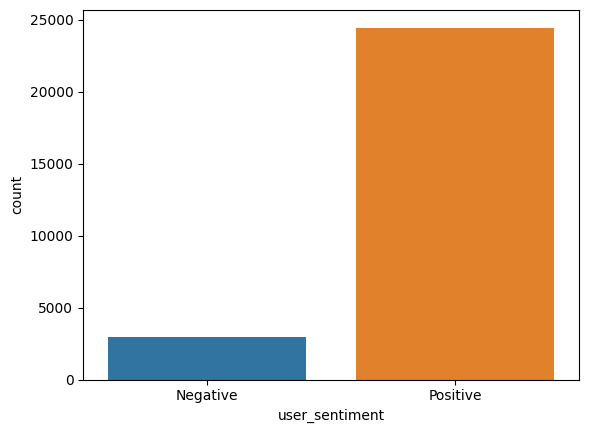

In [17]:
#creating plot to check the ratio of column user_sentiment
plt.figure()
sns.countplot(x = 'user_sentiment', data = df)
plt.show()

**Observation:**

It's clear that there is Class Imbalace which needs to be handled.

We came across some records where user_sentiment was not matching to the reviews and recommendation by the user. Let's handle this by creating new columns as sentiment_true

In [18]:
df['sentiment_true'] = df.apply(lambda x: 'Positive' if ((x.reviews_rating > 2) and (x.reviews_doRecommend)) else 'Negative', axis = 1)

In [19]:
df['sentiment_true'].value_counts()

Positive    25747
Negative     1649
Name: sentiment_true, dtype: int64

In [20]:
df['user_sentiment'].value_counts()

Positive    24460
Negative     2936
Name: user_sentiment, dtype: int64

In [21]:
#checking mismatch in sentiment
df[~(df.sentiment_true == df.user_sentiment)].head()

id      brand  \
9   AV16khLE-jtxr-f38VFn        K-Y   
11  AV16khLE-jtxr-f38VFn        K-Y   
14  AV16khLE-jtxr-f38VFn        K-Y   
42  AV1h6Gu0glJLPUi8IjA_  Johnson's   
54  AV1l8zRZvKc47QAVhnAv       Olay   

                                           categories manufacturer  \
9   Personal Care,Medicine Cabinet,Lubricant/Sperm...          K-Y   
11  Personal Care,Medicine Cabinet,Lubricant/Sperm...          K-Y   
14  Personal Care,Medicine Cabinet,Lubricant/Sperm...          K-Y   
42  Personal Care,Baby Care,Baby Bubble Bath,Baby,...    Johnson's   
54  Personal Care,Skin Care,Anti-Aging,Beauty,Face...          P&G   

                                                 name  \
9                    K-Y Love Sensuality Pleasure Gel   
11                   K-Y Love Sensuality Pleasure Gel   
14                   K-Y Love Sensuality Pleasure Gel   
42          Johnson's Baby Bubble Bath and Wash, 15oz   
54  Olay Regenerist Deep Hydration Regenerating Cream   

                reviews_date reviews_didPurchase reviews_doRecommend  \
9   2016-03-21T00:00:00.000Z               False               False   
11  2016-04-05T00:00:00.000Z               False               False   
14  2016-01-09T00:00:00.000Z               False               False   
42  2014-11-05T00:00:00.000Z               False                True   
54  2014-09-01T00:00:00.000Z               False               False   

    reviews_rating reviews_userCity reviews_userProvince reviews_username  \
9                1             NULL                 NULL         moore222   
11               1             NULL                 NULL           bre234   
14               1             NULL                 NULL           nicole   
42               3             NULL                 NULL   gardenbunny318   
54               1             NULL                 NULL       alnscoob97   

   user_sentiment                                 reviews_title_text  \
9        Positive  Don't buy Got as a surprise for my husband the...   
11       Positive  Waste of Money Purchased this thinking it woul...   
14       Positive  Disappointed First time purchase of this type ...   
42       Negative  It's bubble bath. You would think it's conveni...   
54       Positive  New formula is terrible I used (and loved) thi...   

   sentiment_true  
9        Negative  
11       Negative  
14       Negative  
42       Positive  
54       Negative

**Observation:**

Data looks good and fixed now.

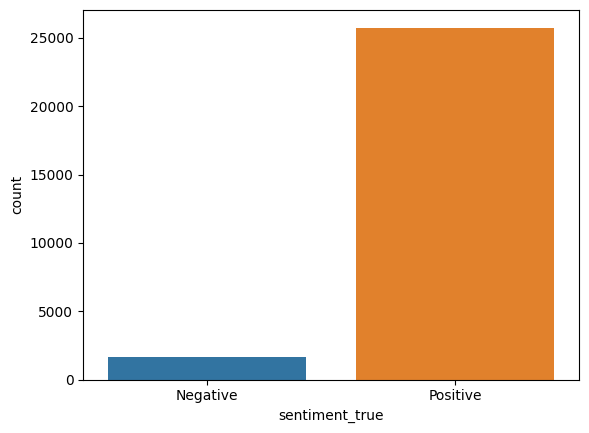

In [22]:
#sentiment_true frequency plot showing class imbalance
sns.countplot(x = 'sentiment_true', data = df)
plt.show()

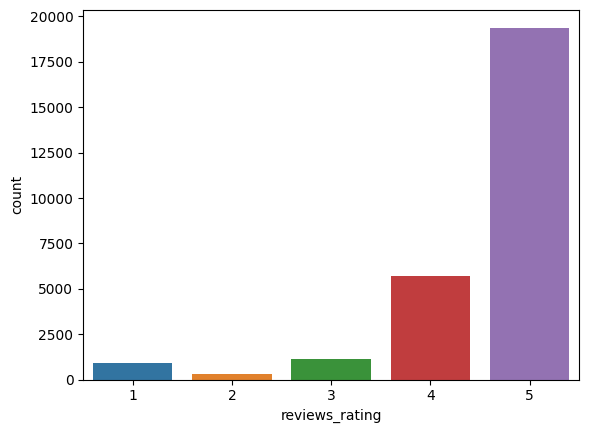

In [23]:
#reviews_rating frequency distribution
sns.countplot(x = 'reviews_rating', data = df)
plt.show()

**OBSERVATION:**

Users are mostly happy as there are more number of higher ratings 4 and 5.

In [24]:
df['reviews_rating'].value_counts()

5    19384
4     5684
3     1148
1      886
2      294
Name: reviews_rating, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

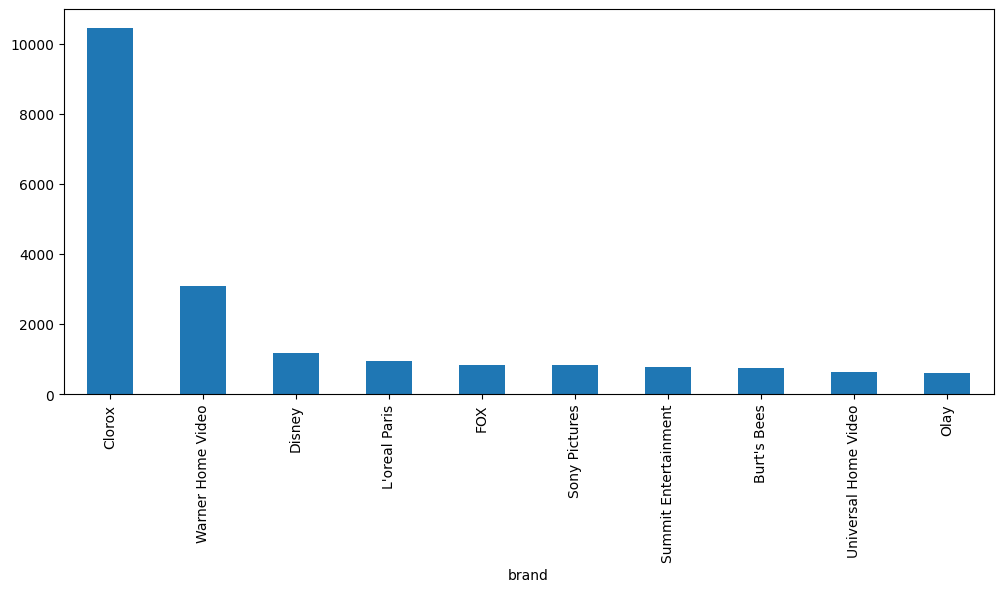

In [25]:
#top 10 recommended brand
plt.figure(figsize = (12, 5))
df[df['sentiment_true'] == 'Positive'].groupby('brand')['brand'].count().sort_values(ascending = False)[:10].plot(kind = 'bar')
plt.show

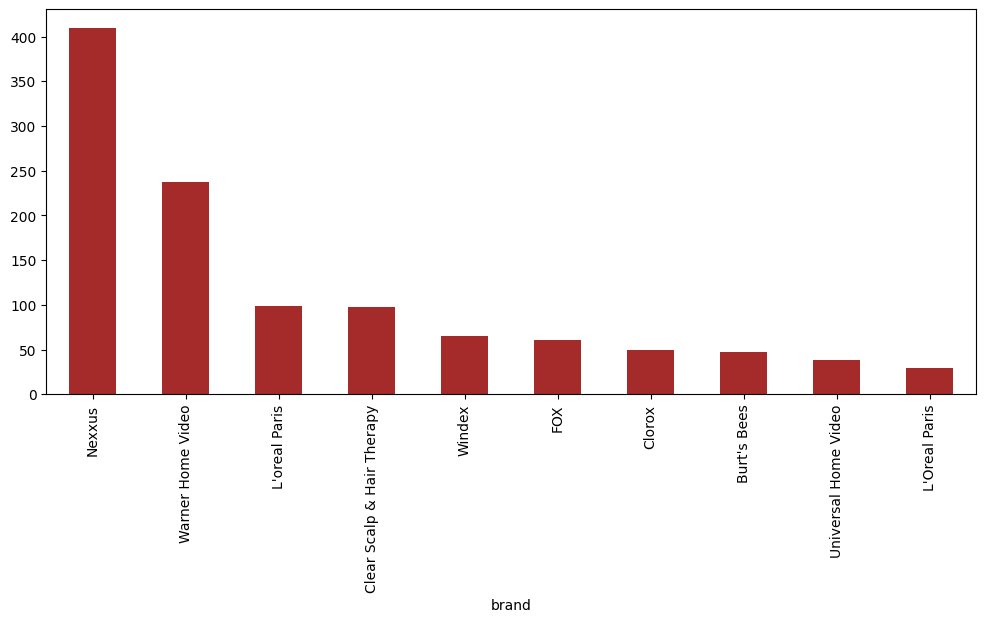

In [26]:
#least favourite 10 brands
plt.figure(figsize=(12,5))
df[df['sentiment_true']=='Negative'].groupby('brand')['brand'].count().sort_values(ascending = False)[:10].plot(kind = 'bar', color = 'brown')
plt.show()

**OBSERVATION:**

Clorox is most favourite brand and Nexxus is least favourite

Warner Home video have mixed reviews with both positive and negative sentiments

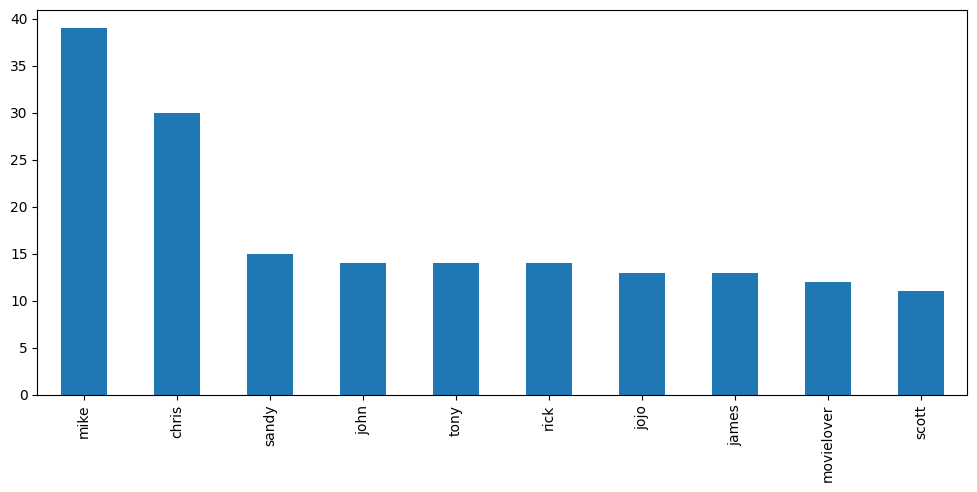

In [27]:
plt.figure(figsize = (12,5))
df['reviews_username'].value_counts()[:10].plot(kind = 'bar')
plt.show()

**Clearing Review Text**

In [28]:
#function to get pos tag used during lemmatization
def get_pos_tag(pos):
  if pos.startswith('J'):
    return wordnet.ADJ
  elif pos.startswith('V'):
    return wordnet.VERB
  elif pos.startswith('R'):
    return wordnet.ADV
  return wordnet.NOUN

In [29]:
#removing the word from the stopwords list which have negative emotions
stopwords_list = set(stopwords.words('english')) - {"doesn't", "don't", "can't", "won't", "isn't", "wasn't", "shouldn't", "wouldn't",
                                                   "couldn't", "no", "not", "never", "nothing", "neither", "none", "nowhere"}

#function to clean the and remove all unnecessary element
def clean_lemmatized_text(text):
  #text to lower
  text = text.lower()

  #removing punctuation
  dictionary = 'abc'.maketrans('', '', string.punctuation)
  text = text.translate(dictionary)

  #tokenizing
  text = [word.replace('[^\w\s]', '') for word in text.split(' ')]

  #removing number
  text = [word for word in text if not any(c.isdigit() for c in word)]

  #removing stopword based on filtered list
  text = [x for x in text if x not in stopwords_list]

  #removing empty tokens
  text = [x for x in text if len(x) > 0]

  #getting pos tag
  pos_tags = pos_tag(text)

  #Lemmatizing the text
  text = [WordNetLemmatizer().lemmatize(word[0], get_pos_tag(word[1])) for word in pos_tags]

  #removing word which are single letter
  text = [word for word in text if len(word) > 1]

  #concatenating to form clean text
  text = ' '.join(text)

  return text

In [30]:
%time
df['clean_review'] = df.apply(lambda x: clean_lemmatized_text(x['reviews_title_text']), axis = 1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.58 µs


In [31]:
#reset index
df.reset_index(inplace = True, drop = True)

In [32]:
#cleaning dataframe for clean lemmatized text
df[['id','reviews_username','sentiment_true','reviews_title_text','clean_review']].head()

id reviews_username sentiment_true  \
0  AV16khLE-jtxr-f38VFn          rebecca       Negative   
1  AV16khLE-jtxr-f38VFn        walker557       Negative   
2  AV16khLE-jtxr-f38VFn         samantha       Negative   
3  AV16khLE-jtxr-f38VFn          raeanne       Negative   
4  AV16khLE-jtxr-f38VFn           kimmie       Negative   

                                  reviews_title_text  \
0  Disappointed I read through the reviews on her...   
1  Irritation My husband bought this gel for us. ...   
2  Not worth it My boyfriend and I bought this to...   
3  Disappointing Bought this earlier today and wa...   
4  Not happy at all I bought this product for my ...   

                                        clean_review  
0  disappoint read review look buy one couple lub...  
1  irritation husband buy gel gel caused irritati...  
2  not worth boyfriend bought spice thing bedroom...  
3  disappoint buy earlier today excite check base...  
4  not happy buy product husband try not impresse...

Positive    93.980873
Negative     6.019127
Name: sentiment_true, dtype: float64


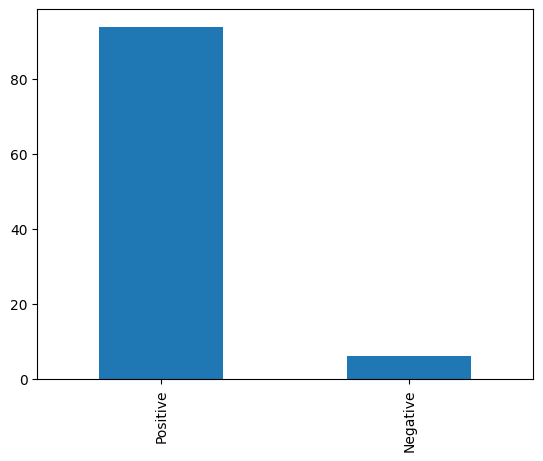

In [33]:
#as we have seen that data contains class imbalance
#checking class imbalance percentance
sentiment_percent = 100 * df['sentiment_true'].value_counts()/len(df)
print(sentiment_percent)
sentiment_percent.plot.bar()
plt.show()

**OBSERVATION:**

Positive sentiment is 94% and negative is almost 6%

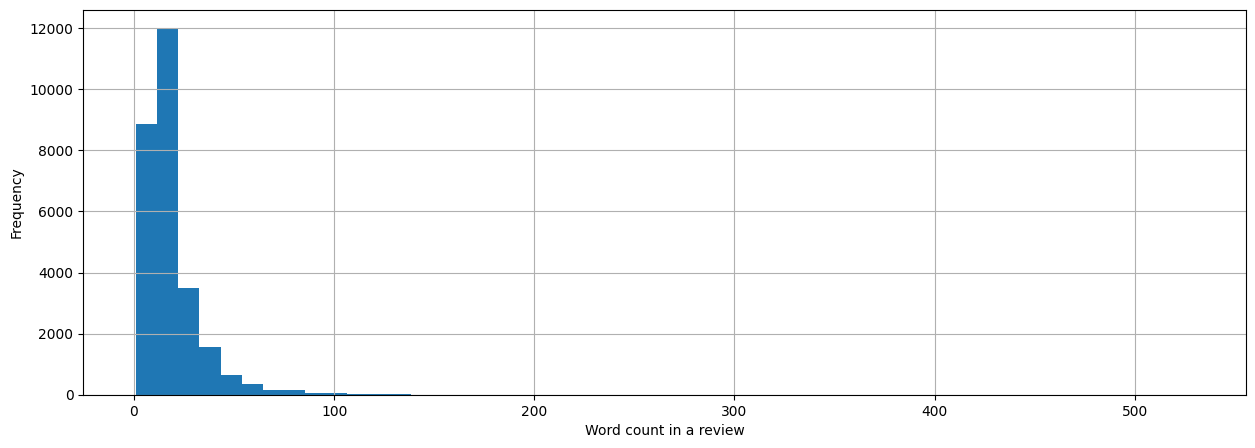

In [34]:
#review length plot
plt.figure(figsize = (15,5))
review_word_count = df.clean_review.apply(lambda x: len(x.split(' ')))
review_word_count.hist(bins = 50)
plt.xlabel('Word count in a review')
plt.ylabel('Frequency')
plt.show()

In [35]:
print('Average number of words per review: ', review_word_count.mean())
print('Skewness: ', review_word_count.skew())

Average number of words per review:  18.761023507081326
Skewness:  5.037542293862477


**WordCloud for the Sentiment**

In [36]:
positive_reviews = df.loc[df.sentiment_true == 'Positive', ['clean_review']]
negative_reviews = df.loc[df.sentiment_true == 'Negative', ['clean_review']]

In [37]:
positive_reviews

clean_review
14     pretty nice buy well review jelly feel like di...
16     love notice product clearance store shop frequ...
17     good time use product couple time since recive...
18     job use time stays bit sticky not bad well pro...
19       great sensation good product give great feeling
...                                                  ...
27391  softness get conditioner influenster try im lo...
27392  love love receive review purpose influenster l...
27393  hair smooth use first love smell product wash ...
27394  perfect oily hair receive influenster never go...
27395  condition healthy receive product complimentar...

[25747 rows x 1 columns]

In [38]:
negative_reviews

clean_review
0      disappoint read review look buy one couple lub...
1      irritation husband buy gel gel caused irritati...
2      not worth boyfriend bought spice thing bedroom...
3      disappoint buy earlier today excite check base...
4      not happy buy product husband try not impresse...
...                                                  ...
26734  decent conditioner great price receive along c...
26758  good smell little heavy really love way condit...
26778  smell great conditioner great although wasnt s...
27224  amaze get influenster voxbox im glad extraordi...
27299  love dark brown curly hair love way work hair ...

[1649 rows x 1 columns]

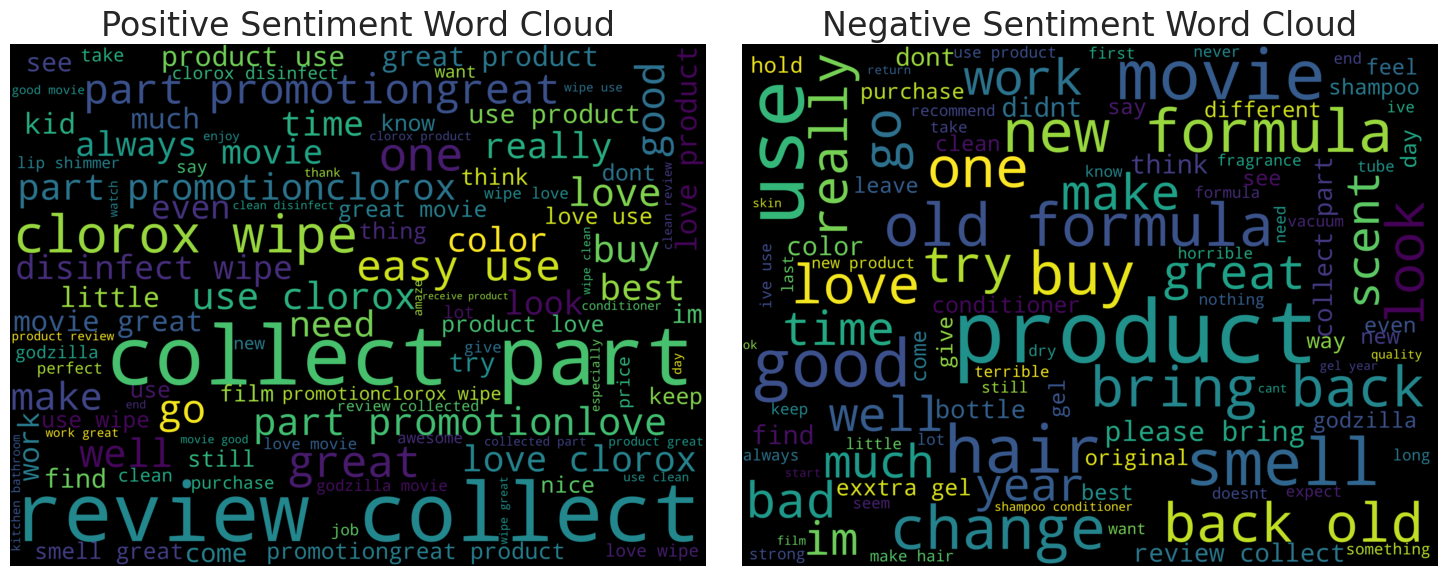

In [39]:
#wordcloud for positive_reviews
sns.set(font_scale = 2)
plt.figure(figsize = (15,10))

#wordcloud for positive sentiment
plt.subplot(1,2,1)
plt.title('Positive Sentiment Word Cloud')

word_cloud_text = ''.join(positive_reviews['clean_review'])
wordcloud = WordCloud(max_font_size = 100, #maximum font size for the most frequent word
                      max_words = 100, #max number of words
                      background_color = 'Black', #background color
                      scale = 10, #scaling between computation and drawing
                      width = 800, #width of the canvas
                      height = 600 #height of the canvas
                      ).generate(word_cloud_text)

plt.imshow(wordcloud, interpolation = 'bilinear') #to make the display image appear smooth
plt.axis('off')
plt.tight_layout()

#wordcloud for negative sentiment
plt.subplot(1,2,2)
plt.title('Negative Sentiment Word Cloud')

word_cloud_text = ''.join(negative_reviews['clean_review'])
wordcloud = WordCloud(max_font_size = 100, #maximum font size for the most frequent word
                      max_words = 100, #max number of words
                      background_color = 'Black', #background color
                      scale = 10, #scaling between computation and drawing
                      width = 800, #width of the canvas
                      height = 600 #height of the canvas
                      ).generate(word_cloud_text)

plt.imshow(wordcloud, interpolation = 'bilinear') #to make the display image appear smooth
plt.axis('off')
plt.tight_layout()

In [40]:
#mapping positive sentiments to 1 and vice versa
df['sentiment_encoded'] = np.where(df['sentiment_true'] == 'Positive', 1, 0)
df['sentiment_encoded'].value_counts()

1    25747
0     1649
Name: sentiment_encoded, dtype: int64

In [41]:
df[['id', 'reviews_username','clean_review', 'sentiment_encoded']].head(15)

id reviews_username  \
0   AV16khLE-jtxr-f38VFn          rebecca   
1   AV16khLE-jtxr-f38VFn        walker557   
2   AV16khLE-jtxr-f38VFn         samantha   
3   AV16khLE-jtxr-f38VFn          raeanne   
4   AV16khLE-jtxr-f38VFn           kimmie   
5   AV16khLE-jtxr-f38VFn           cassie   
6   AV16khLE-jtxr-f38VFn         moore222   
7   AV16khLE-jtxr-f38VFn          jds1992   
8   AV16khLE-jtxr-f38VFn           bre234   
9   AV16khLE-jtxr-f38VFn          jds1992   
10  AV16khLE-jtxr-f38VFn         gordy313   
11  AV16khLE-jtxr-f38VFn           nicole   
12  AV16khLE-jtxr-f38VFn          cvperez   
13  AV16khLE-jtxr-f38VFn          sanchez   
14  AV16khLE-jtxr-f38VFn             ll24   

                                         clean_review  sentiment_encoded  
0   disappoint read review look buy one couple lub...                  0  
1   irritation husband buy gel gel caused irritati...                  0  
2   not worth boyfriend bought spice thing bedroom...                  0  
3   disappoint buy earlier today excite check base...                  0  
4   not happy buy product husband try not impresse...                  0  
5   disappointing husband buy extra fun werevboth ...                  0  
6   dont buy get surprise husband nothing special ...                  0  
7   pretty dissapoitned tried husband felt no diff...                  0  
8   waste money purchase think would sort warm eff...                  0  
9   waste money buy enhance time bit abslutely not...                  0  
10  not happy product buy really like variety noth...                  0  
11  disappoint first time purchase type product ma...                  0  
12  not expect buy tried wife not enjoy not feel a...                  0  
13  disappointed buy try spice thing felt nothing ...                  0  
14  pretty nice buy well review jelly feel like di...                  1

In [42]:
#function to check frequency
def Most_Freq_Words(reviews, n_most_common):

  #creating list of words in lowercase
  flattened_reviews = [word for review in reviews for word in \
                       review.lower().split()]

  #removing punctuation
  flattened_reviews = [''.join(char for char in review if \
                               char not in string.punctuation) for \
                       review in flattened_reviews]

  #removing empty strings from list
  flattened_reviews = [review for review in flattened_reviews if review]

  return Counter(flattened_reviews).most_common(n_most_common)

In [43]:
pos_reviews = df[df['sentiment_encoded'] == 1]
Most_Freq_Words(pos_reviews['clean_review'], 10)

[('great', 13791),
 ('love', 11882),
 ('use', 11093),
 ('movie', 10293),
 ('product', 10205),
 ('review', 8590),
 ('part', 8471),
 ('wipe', 8201),
 ('promotion', 8144),
 ('clean', 7877)]

In [44]:
neg_reviews = df[df['sentiment_encoded'] == 0]
Most_Freq_Words(neg_reviews['clean_review'], 10)

[('not', 1277),
 ('product', 1038),
 ('use', 920),
 ('formula', 879),
 ('new', 781),
 ('hair', 759),
 ('old', 637),
 ('gel', 561),
 ('like', 539),
 ('movie', 537)]

**Observation:**

The most frequent words for both positive and negative reviews are in line with word cloud

# FEATURE EXTRACTION Using TF_IDF Vectorizer

In [45]:
tf_idf_vectorizer = TfidfVectorizer(
    stop_words = list(stopwords_list),
    max_features = 2000,
    max_df = 0.9,
    strip_accents = 'unicode',
    analyzer = 'word',
    token_pattern = r'\w{1,}',
    tokenizer = word_tokenize,
    ngram_range = (1, 3),
    sublinear_tf = True)

In [46]:
X_tfidf= tf_idf_vectorizer.fit_transform(df['clean_review'])

In [47]:
X_tfidf.shape

(27396, 2000)

In [48]:
print(tf_idf_vectorizer.get_feature_names_out())

['able' 'absolute' 'absolutely' ... 'yr' 'yummy' 'zombie']


In [49]:
#saving tf-idf vectorizer pickle file
filename = 'tfidf_vectorizer.pkl'
with open(filename, 'wb') as file:
  pickle.dump(tf_idf_vectorizer, file)

In [50]:
#loading tf-idf vectorizer pickle file
with open(filename, 'rb') as file:
  tf_idf_vectorizer = pickle.load(file)

# Train Test Data Split

In [51]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, df['sentiment_encoded'], test_size = 0.2, random_state = 42)

In [52]:
print('X_train_tfidf : ', X_train_tfidf.shape)
print('X_test_tfidf : ', X_test_tfidf.shape)
print('y_train_tfidf : ', y_train_tfidf.shape)
print('y_test_tfidf : ', y_test_tfidf.shape)

X_train_tfidf :  (21916, 2000)
X_test_tfidf :  (5480, 2000)
y_train_tfidf :  (21916,)
y_test_tfidf :  (5480,)


In [53]:
y_train_tfidf.value_counts()

1    20579
0     1337
Name: sentiment_encoded, dtype: int64

In [54]:
y_test_tfidf.value_counts()

1    5168
0     312
Name: sentiment_encoded, dtype: int64

# Classification - Model Building

**1. Logistic Regression**

WITHOUT SMOTE

In [55]:
%time
lr = LogisticRegression(random_state = 42)
lr.fit(X_train_tfidf, y_train_tfidf.ravel())

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.7 µs


LogisticRegression(random_state=42)

In [56]:
#predicting train data
y_pred_train_lr = lr.predict(X_train_tfidf)

In [57]:
#creating report summary
def get_Report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  print('*'*80)
  print(' ')

  print('Accuracy : ', accuracy_score(y_true, y_pred))
  print('Recall : ', recall_score(y_true, y_pred))
  print('Precision : ', precision_score(y_true, y_pred))
  print('F1_Score : ', f1_score(y_true, y_pred))
  print('*'*80)
  print(' ')

  #Confusion Matrix
  sns.set_context('paper', rc = {'font.size':15, 'axes.titlesize':15, 'axes.labelsize':15})
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_true, y_pred), display_labels = [0,1])
  cm_display.plot()
  plt.show()
  print('*'*80)
  print(' ')

  #ROC curve
  metrics.RocCurveDisplay.from_predictions(y_true, y_pred)
  metrics_summary = []
  metrics_summary.append(round(accuracy_score(y_true, y_pred),2))
  metrics_summary.append(round(recall_score(y_true, y_pred),2))
  metrics_summary.append(round(precision_score(y_true, y_pred),2))
  metrics_summary.append(round(f1_score(y_true, y_pred),2))
  return metrics_summary

              precision    recall  f1-score   support

           0       0.94      0.48      0.64      1337
           1       0.97      1.00      0.98     20579

    accuracy                           0.97     21916
   macro avg       0.96      0.74      0.81     21916
weighted avg       0.97      0.97      0.96     21916

********************************************************************************
 
Accuracy :  0.9666453732432926
Recall :  0.9981534574080373
Precision :  0.967363662051427
F1_Score :  0.9825173988950805
********************************************************************************
 


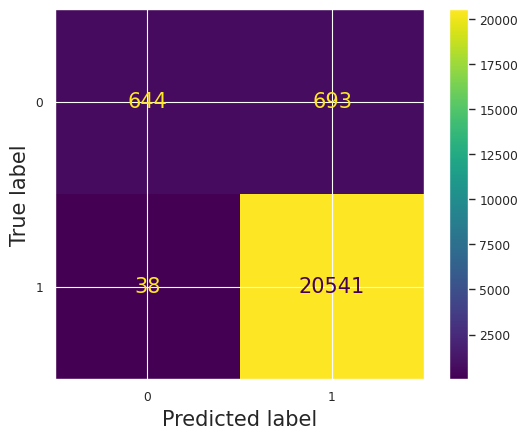

********************************************************************************
 


[0.97, 1.0, 0.97, 0.98]

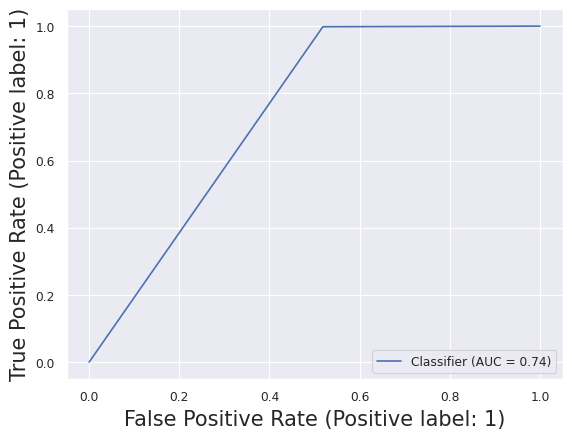

In [58]:
#performance report on Train Data
get_Report(y_train_tfidf, y_pred_train_lr)

Logistic Regression accuracy 0.9656934306569344
              precision    recall  f1-score   support

           0       0.92      0.44      0.59       312
           1       0.97      1.00      0.98      5168

    accuracy                           0.97      5480
   macro avg       0.94      0.72      0.79      5480
weighted avg       0.96      0.97      0.96      5480

********************************************************************************
 
Accuracy :  0.9656934306569344
Recall :  0.9976780185758514
Precision :  0.9669917479369843
F1_Score :  0.9820952380952381
********************************************************************************
 


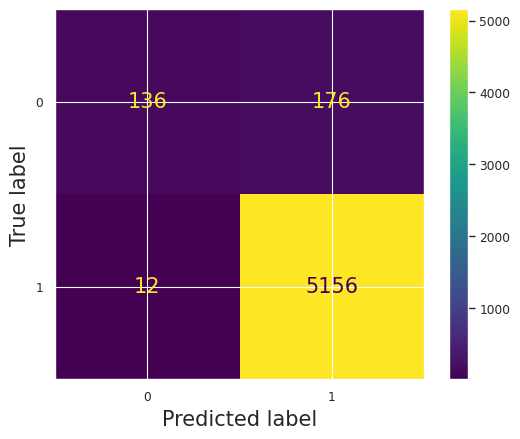

********************************************************************************
 


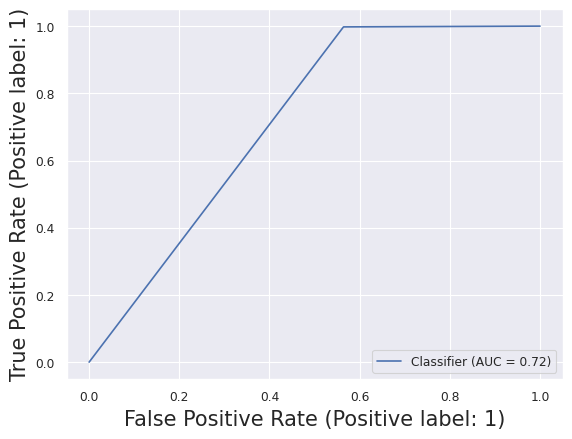

In [59]:
#prediction on Test Data
y_pred_test_lr = lr.predict(X_test_tfidf)

#performance report on Test data
print("Logistic Regression accuracy", accuracy_score(y_test_tfidf, y_pred_test_lr))
lr_test_perf = get_Report(y_test_tfidf, y_pred_test_lr)

In [60]:
#model comparion computation
df_compare_metrics = pd.DataFrame({'Metrics' :['Accuracy', 'Recall', 'Precision', 'F1_Score'], 'LR w/o Smote': lr_test_perf},
                                  columns = ['Metrics', 'LR w/o Smote'])

df_compare_metrics

Metrics  LR w/o Smote
0   Accuracy          0.97
1     Recall          1.00
2  Precision          0.97
3   F1_Score          0.98

LR WITH SMOTE

In [61]:
counter = Counter(y_train_tfidf)
print('Before', counter)

Before Counter({1: 20579, 0: 1337})


In [62]:
sm = SMOTE()

#class imbalance treated with smote
X_train_tfidf_sm, y_train_tfidf_sm = sm.fit_resample(X_train_tfidf, y_train_tfidf)

#checking the count
counter = Counter(y_train_tfidf_sm)
print('After', counter)

After Counter({1: 20579, 0: 20579})


In [63]:
%time
lr = LogisticRegression()
lr.fit(X_train_tfidf_sm, y_train_tfidf_sm.ravel())

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11 µs


LogisticRegression()

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     20579
           1       0.96      0.94      0.95     20579

    accuracy                           0.95     41158
   macro avg       0.95      0.95      0.95     41158
weighted avg       0.95      0.95      0.95     41158

********************************************************************************
 
Accuracy :  0.9522328587394917
Recall :  0.9410078235094028
Precision :  0.9626186807178009
F1_Score :  0.9516905838411638
********************************************************************************
 


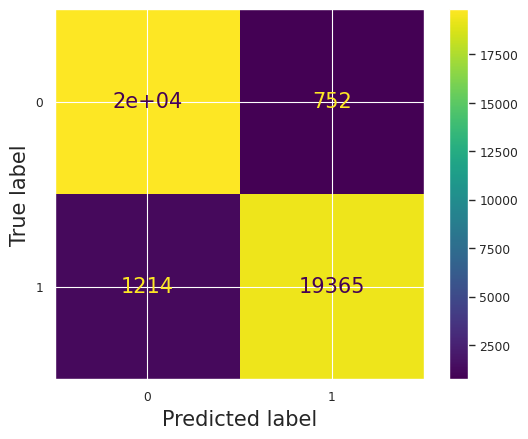

********************************************************************************
 


[0.95, 0.94, 0.96, 0.95]

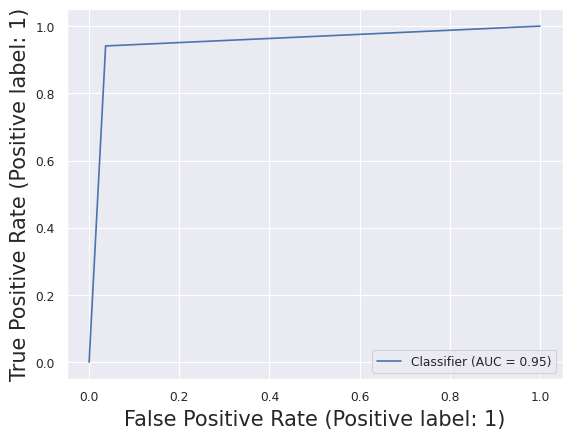

In [64]:
#predicting Train Data
y_pred_train_lr_sm = lr.predict(X_train_tfidf_sm)

#performance report on Train Data
get_Report(y_train_tfidf_sm, y_pred_train_lr_sm)

In [65]:
#predicting on Test Data
y_pred_test_lr_sm = lr.predict(X_test_tfidf)

Logistic Regression Accuracy 0.926094890510949
              precision    recall  f1-score   support

           0       0.42      0.82      0.56       312
           1       0.99      0.93      0.96      5168

    accuracy                           0.93      5480
   macro avg       0.71      0.87      0.76      5480
weighted avg       0.96      0.93      0.94      5480

********************************************************************************
 
Accuracy :  0.926094890510949
Recall :  0.9326625386996904
Precision :  0.9883124871847447
F1_Score :  0.9596814335490294
********************************************************************************
 


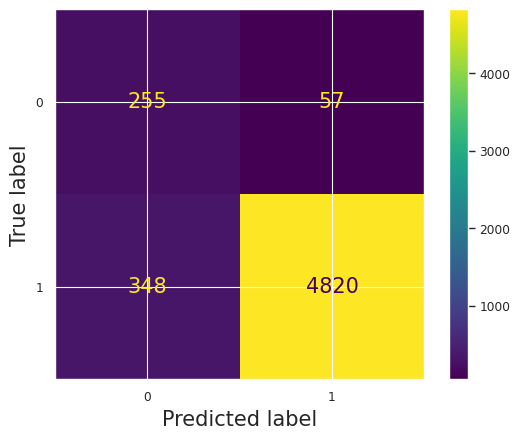

********************************************************************************
 


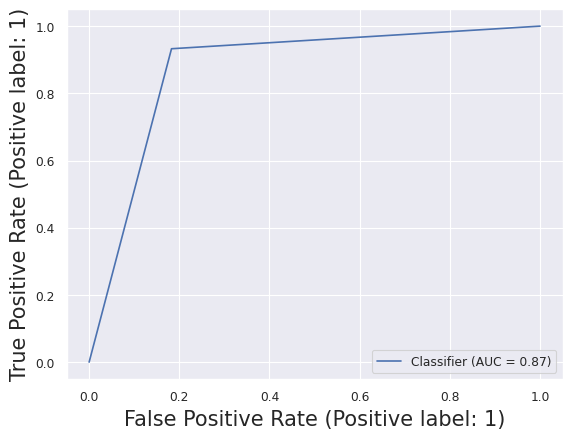

In [66]:
#performace on Test Data
print('Logistic Regression Accuracy', accuracy_score(y_test_tfidf, y_pred_test_lr_sm))
lr_test_perf_sm = get_Report(y_test_tfidf, y_pred_test_lr_sm)

In [67]:
df_compare_metrics['LR with Smote'] = lr_test_perf_sm
df_compare_metrics

Metrics  LR w/o Smote  LR with Smote
0   Accuracy          0.97           0.93
1     Recall          1.00           0.93
2  Precision          0.97           0.99
3   F1_Score          0.98           0.96

In [68]:
#saving the model
filename = 'logistic_reg_model.pkl'
with open(filename, 'wb') as file:
  pickle.dump(lr, file)

In [69]:
#load from file
with open(filename, 'rb') as file:
    pickled_model_lr = pickle.load(file)

**2. Random Forest**


Using GridSearchCV to find the best estimator

In [70]:
params = {
    'max_features' : [10, 20],
    'max_depth': [10, 20],
    'min_samples_leaf': [50, 100],
    'min_samples_split': [200],
    'n_estimators': [100, 200],
}

rf = RandomForestClassifier(random_state = 42)
grid_search = GridSearchCV(estimator = rf,
                           param_grid = params,
                           cv = 4,
                           scoring = 'precision',
                           n_jobs = -1,
                           verbose = 1)

In [71]:
%time
grid_search.fit(X_train_tfidf_sm, y_train_tfidf_sm)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs
Fitting 4 folds for each of 16 candidates, totalling 64 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'max_features': [10, 20],
                         'min_samples_leaf': [50, 100],
                         'min_samples_split': [200],
                         'n_estimators': [100, 200]},
             scoring='precision', verbose=1)

In [72]:
print('Best Precision Score', grid_search.best_score_)
print('Best Estimator', grid_search.best_estimator_)
print('Best Params', grid_search.best_params_)

Best Precision Score 0.886595824408747
Best Estimator RandomForestClassifier(max_depth=20, max_features=20, min_samples_leaf=50,
                       min_samples_split=200, random_state=42)
Best Params {'max_depth': 20, 'max_features': 20, 'min_samples_leaf': 50, 'min_samples_split': 200, 'n_estimators': 100}


In [73]:
#initialising for best estimator
rfc = RandomForestClassifier(
    max_depth = 20,
    max_features = 20,
    min_samples_leaf = 50,
    min_samples_split = 200,
    n_estimators = 100,
    random_state = 42,
    bootstrap = True,
    n_jobs = -1,
    verbose = 1)

In [74]:
#fitting on train data
%time
rfc.fit(X_train_tfidf_sm, y_train_tfidf_sm)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.2 µs


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


RandomForestClassifier(max_depth=20, max_features=20, min_samples_leaf=50,
                       min_samples_split=200, n_jobs=-1, random_state=42,
                       verbose=1)

In [75]:
#predicting on train data
y_pred_train_rfc_sm = rfc.predict(X_train_tfidf_sm)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished


Random Forest Classifier Accuracy 0.899387725351086
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     20579
           1       0.89      0.91      0.90     20579

    accuracy                           0.90     41158
   macro avg       0.90      0.90      0.90     41158
weighted avg       0.90      0.90      0.90     41158

********************************************************************************
 
Accuracy :  0.899387725351086
Recall :  0.9097623791243501
Precision :  0.8912691611920404
F1_Score :  0.9004208248166407
********************************************************************************
 


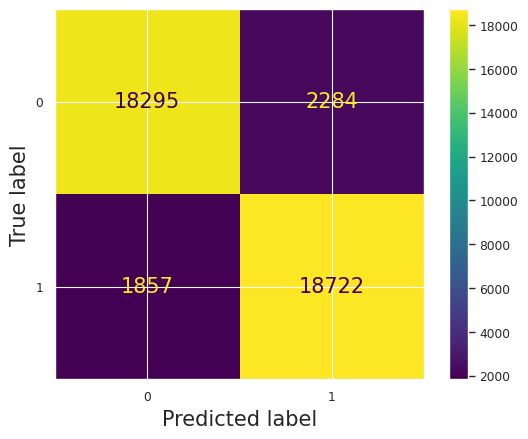

********************************************************************************
 


[0.9, 0.91, 0.89, 0.9]

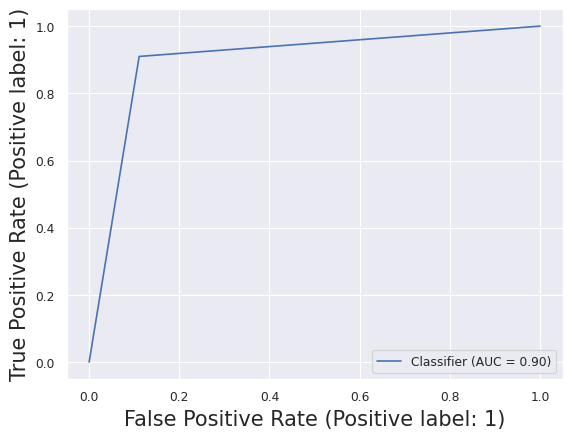

In [76]:
#generating performance report on train data with smote
print('Random Forest Classifier Accuracy', accuracy_score(y_train_tfidf_sm, y_pred_train_rfc_sm))
get_Report(y_train_tfidf_sm, y_pred_train_rfc_sm)

In [77]:
#prediction on test data
y_pred_test_rfc_sm = rfc.predict(X_test_tfidf)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.33      0.72      0.46       312
           1       0.98      0.91      0.95      5168

    accuracy                           0.90      5480
   macro avg       0.66      0.82      0.70      5480
weighted avg       0.95      0.90      0.92      5480

********************************************************************************
 
Accuracy :  0.9023722627737226
Recall :  0.913312693498452
Precision :  0.9819013938007073
F1_Score :  0.9463659147869674
********************************************************************************
 


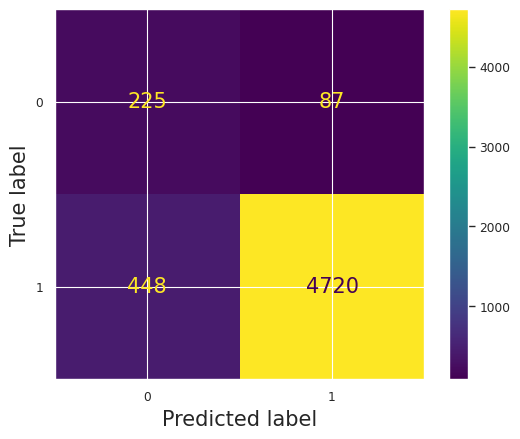

********************************************************************************
 


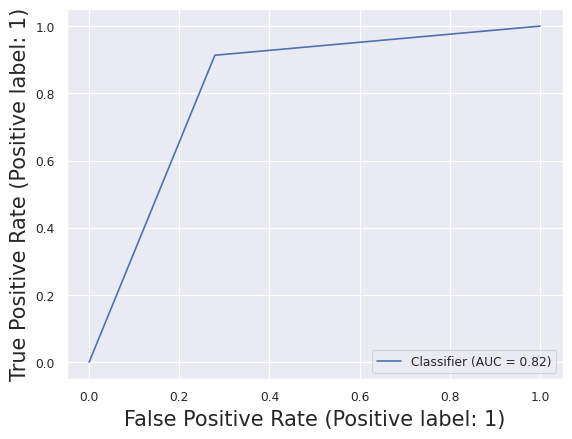

In [78]:
#generating performance report on test data with Smote
rf_test_perf_sm = get_Report(y_test_tfidf, y_pred_test_rfc_sm)

In [79]:
df_compare_metrics['RF Tuned'] = rf_test_perf_sm
df_compare_metrics

Metrics  LR w/o Smote  LR with Smote  RF Tuned
0   Accuracy          0.97           0.93      0.90
1     Recall          1.00           0.93      0.91
2  Precision          0.97           0.99      0.98
3   F1_Score          0.98           0.96      0.95

In [80]:
#saving Random Forest Model
filename = 'random_forest_model.pkl'
with open(filename, 'wb') as file:
  pickle.dump(rfc, file)

**3. Naive Bayes**

In [81]:
nb = MultinomialNB()

In [82]:
%time
nb.fit(X_train_tfidf_sm, y_train_tfidf_sm)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


MultinomialNB()

In [83]:
#predicting on train data
predict_train_nb_sm = nb.predict(X_train_tfidf_sm)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     20579
           1       0.93      0.86      0.89     20579

    accuracy                           0.90     41158
   macro avg       0.90      0.90      0.90     41158
weighted avg       0.90      0.90      0.90     41158

********************************************************************************
 
Accuracy :  0.8963263521065163
Recall :  0.8585937120365421
Precision :  0.928676547881846
F1_Score :  0.8922610781466987
********************************************************************************
 


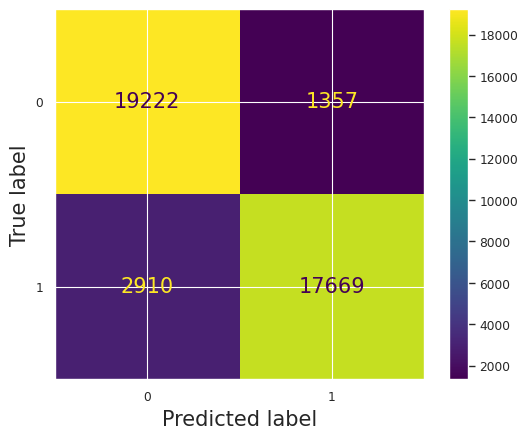

********************************************************************************
 


[0.9, 0.86, 0.93, 0.89]

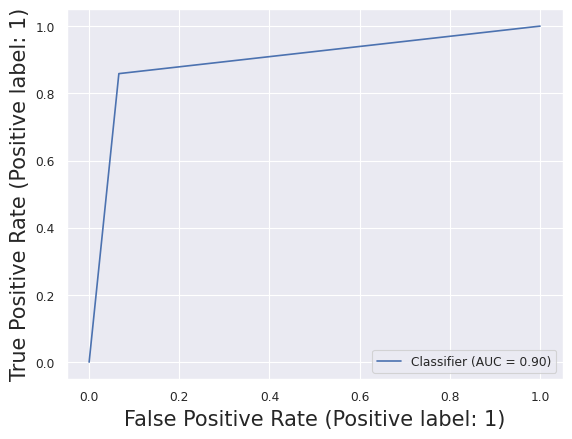

In [84]:
#generating performance report on train data with smote
get_Report(y_train_tfidf_sm, predict_train_nb_sm)

In [85]:
#predicting on test data
predict_test_nb_sm = nb.predict(X_test_tfidf)

              precision    recall  f1-score   support

           0       0.27      0.88      0.41       312
           1       0.99      0.86      0.92      5168

    accuracy                           0.86      5480
   macro avg       0.63      0.87      0.67      5480
weighted avg       0.95      0.86      0.89      5480

********************************************************************************
 
Accuracy :  0.8583941605839416
Recall :  0.8571981424148607
Precision :  0.9914950760966875
F1_Score :  0.9194686591946866
********************************************************************************
 


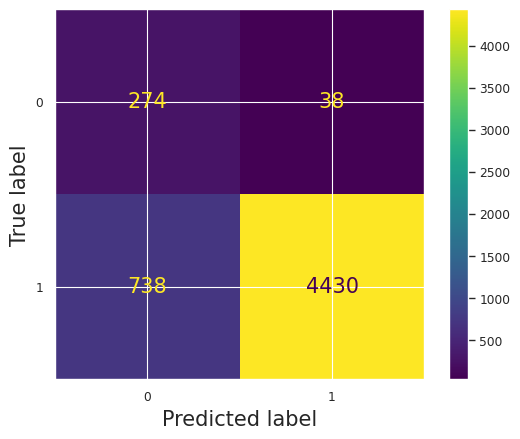

********************************************************************************
 


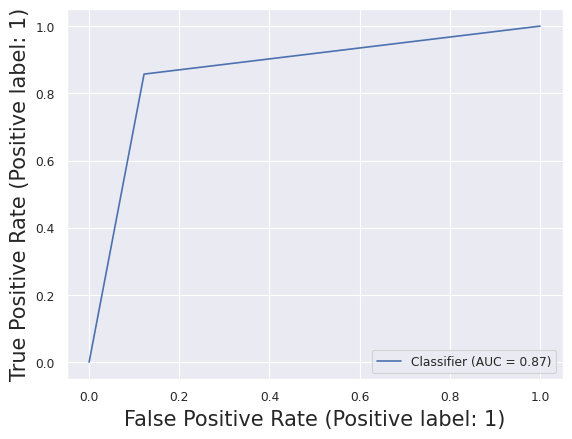

In [86]:
#generating performance report on test data with smote
nb_test_perf_sm = get_Report(y_test_tfidf, predict_test_nb_sm)

In [87]:
df_compare_metrics['Naive Bayes'] = nb_test_perf_sm
df_compare_metrics

Metrics  LR w/o Smote  LR with Smote  RF Tuned  Naive Bayes
0   Accuracy          0.97           0.93      0.90         0.86
1     Recall          1.00           0.93      0.91         0.86
2  Precision          0.97           0.99      0.98         0.99
3   F1_Score          0.98           0.96      0.95         0.92

In [88]:
#saving naaive bayes model
filename = 'naive_bayes_model.pkl'
with open(filename, 'wb') as file:
  pickle.dump(nb, file)

**4. XGBoost**

In [89]:
xg = xgb.XGBClassifier(random_State = 42)

In [90]:
%time
xg.fit(X_train_tfidf_sm, y_train_tfidf_sm)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs
[01:14:31] WARNING: ../src/learner.cc:767: 
Parameters: { "random_State" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_State=42, ...)

In [91]:
#predicting on train data
predict_train_xg_sm = xg.predict(X_train_tfidf_sm)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     20579
           1       0.97      0.99      0.98     20579

    accuracy                           0.98     41158
   macro avg       0.98      0.98      0.98     41158
weighted avg       0.98      0.98      0.98     41158

********************************************************************************
 
Accuracy :  0.9814373876281647
Recall :  0.9884834054132854
Precision :  0.9747472327375533
F1_Score :  0.9815672650067555
********************************************************************************
 


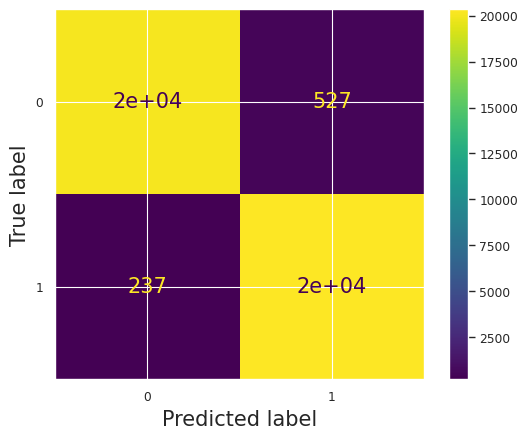

********************************************************************************
 


[0.98, 0.99, 0.97, 0.98]

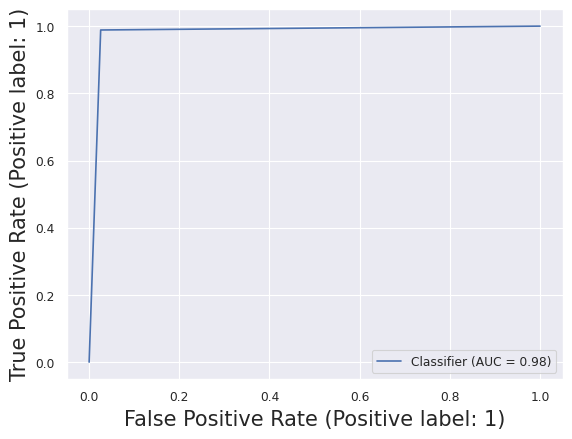

In [92]:
#generating performance report on train data with smote
get_Report(y_train_tfidf_sm, predict_train_xg_sm)

In [93]:
#predicting on test data
predict_test_xg_sm = xg.predict(X_test_tfidf)

              precision    recall  f1-score   support

           0       0.59      0.65      0.62       312
           1       0.98      0.97      0.98      5168

    accuracy                           0.95      5480
   macro avg       0.79      0.81      0.80      5480
weighted avg       0.96      0.95      0.96      5480

********************************************************************************
 
Accuracy :  0.9545620437956205
Recall :  0.9731037151702786
Precision :  0.9785950574041642
F1_Score :  0.9758416610070826
********************************************************************************
 


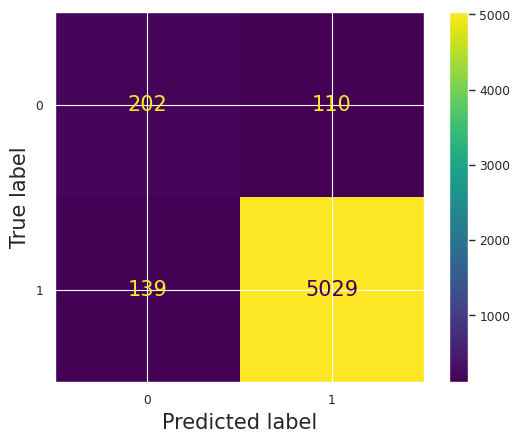

********************************************************************************
 


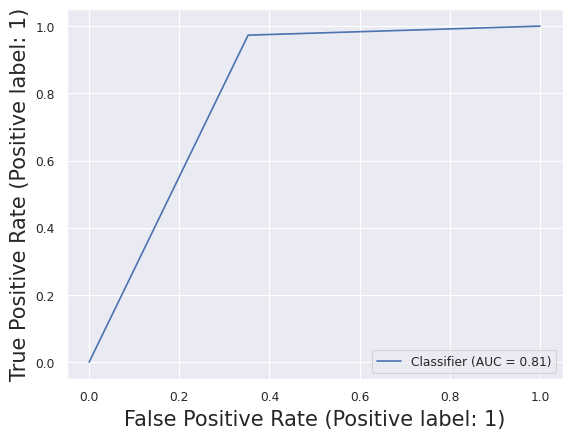

In [94]:
#generating performance report on test data with smote
xg_test_perf_sm = get_Report(y_test_tfidf, predict_test_xg_sm)

In [95]:
df_compare_metrics['XGB'] = xg_test_perf_sm
df_compare_metrics

Metrics  LR w/o Smote  LR with Smote  RF Tuned  Naive Bayes   XGB
0   Accuracy          0.97           0.93      0.90         0.86  0.95
1     Recall          1.00           0.93      0.91         0.86  0.97
2  Precision          0.97           0.99      0.98         0.99  0.98
3   F1_Score          0.98           0.96      0.95         0.92  0.98

**5. XGBoost Tuned**

In [96]:
xg_grid = {'learning_rate':[0.30, 0.45],
           "max_depth": [5,10]}

In [97]:
xg_hpt = GridSearchCV(XGBClassifier(random_state = 42),
                      param_grid = xg_grid,
                      cv = 5,
                      verbose = True,
                      n_jobs = -1,
                      scoring = 'f1')

#fit random hyperparameter search model
xg_hpt.fit(X_train_tfidf_sm, y_train_tfidf_sm)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,..._bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.3, 0.45], 'max_depth': [5, 10]},
             scoring='f1', verbose=True)

In [98]:
xg_hpt.best_params_

{'learning_rate': 0.45, 'max_depth': 10}

In [99]:
#initialising for the best estimator
xg_hpt = XGBClassifier(max_depth = 10,
                       learning_rate = 0.45,
                       random_state = 42,
                       bootstrap = True,
                       n_jobs = -1,
                       verbose = 1)

In [100]:
#fitting train data
%time
xg_hpt.fit(X_train_tfidf_sm, y_train_tfidf_sm)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs
[01:35:30] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "verbose" } are not used.



XGBClassifier(base_score=None, booster=None, bootstrap=True, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.45, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, ...)

In [101]:
#predicting on train data
predict_train_xg_hpt_sm = xg_hpt.predict(X_train_tfidf_sm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20579
           1       1.00      1.00      1.00     20579

    accuracy                           1.00     41158
   macro avg       1.00      1.00      1.00     41158
weighted avg       1.00      1.00      1.00     41158

********************************************************************************
 
Accuracy :  0.997570338694786
Recall :  0.9987365761212887
Precision :  0.996412469093906
F1_Score :  0.9975731689559773
********************************************************************************
 


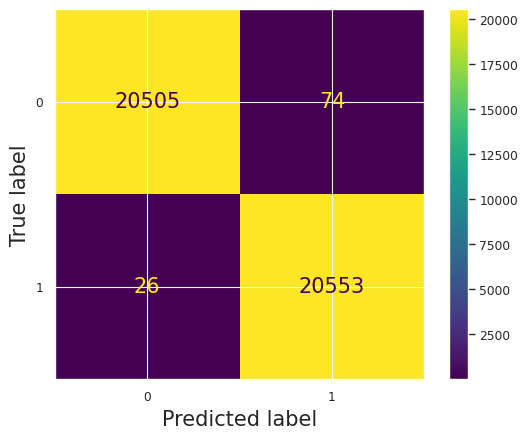

********************************************************************************
 


[1.0, 1.0, 1.0, 1.0]

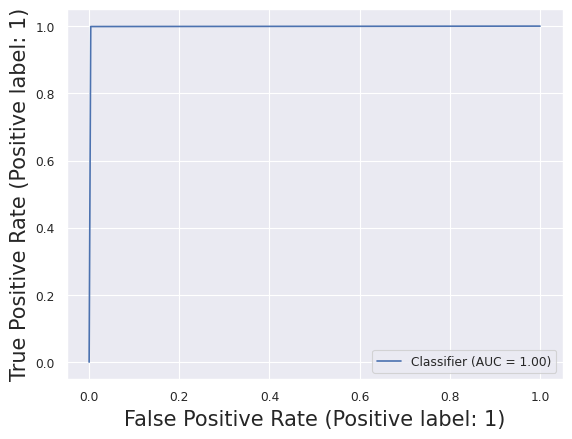

In [102]:
#generating report on train data
get_Report(y_train_tfidf_sm, predict_train_xg_hpt_sm)

In [103]:
#predicting on test data
predic_test_xg_hpt_sm = xg_hpt.predict(X_test_tfidf)

              precision    recall  f1-score   support

           0       0.64      0.60      0.62       312
           1       0.98      0.98      0.98      5168

    accuracy                           0.96      5480
   macro avg       0.81      0.79      0.80      5480
weighted avg       0.96      0.96      0.96      5480

********************************************************************************
 
Accuracy :  0.9578467153284671
Recall :  0.9794891640866873
Precision :  0.9759012916907653
F1_Score :  0.977691936262675
********************************************************************************
 


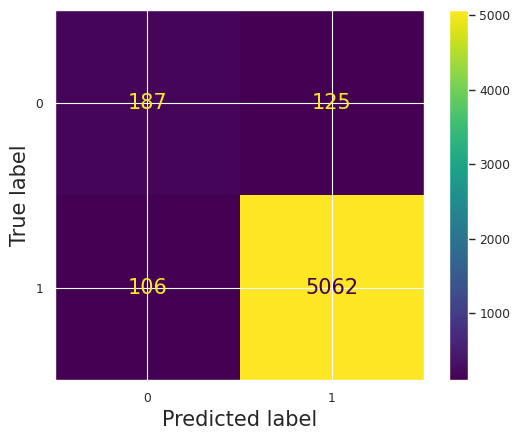

********************************************************************************
 


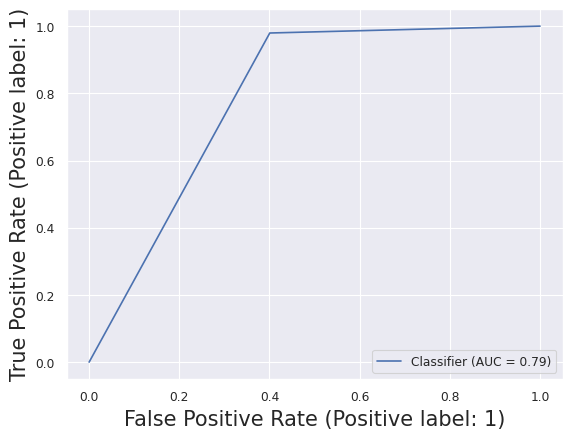

In [104]:
#generating report on test data with smote
xg_hpt_test_perf_sm = get_Report(y_test_tfidf, predic_test_xg_hpt_sm)

In [105]:
df_compare_metrics['XGB_Tuned'] = xg_hpt_test_perf_sm
df_compare_metrics

Metrics  LR w/o Smote  LR with Smote  RF Tuned  Naive Bayes   XGB  \
0   Accuracy          0.97           0.93      0.90         0.86  0.95   
1     Recall          1.00           0.93      0.91         0.86  0.97   
2  Precision          0.97           0.99      0.98         0.99  0.98   
3   F1_Score          0.98           0.96      0.95         0.92  0.98   

   XGB_Tuned  
0       0.96  
1       0.98  
2       0.98  
3       0.98

In [106]:
#saving xgb_tuned model
filename = 'xgboost_tuned_model.pkl'
with open(filename, 'wb') as file:
  pickle.dump(xg_hpt, file)

**Observation :**

*   Based on the above table, we can see that Logistic Regression and XGBoost Tuned have performed well
*   The metric of importance here is Prediction and F1 Score
*   The AUC for LR and XGB Tuned are 0.87 & 0.79 respectively.
*   Based on above observation and simplicity of model, we will choose Logistic Regression as our final model for prediction purpose


Note - We will pick the LR Model on smote data as there was class imbalace






# Recommendation System

**User Based Collaborative Filtering**

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27396 entries, 0 to 27395
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    27396 non-null  object
 1   brand                 27396 non-null  object
 2   categories            27396 non-null  object
 3   manufacturer          27396 non-null  object
 4   name                  27396 non-null  object
 5   reviews_date          27396 non-null  object
 6   reviews_didPurchase   27396 non-null  object
 7   reviews_doRecommend   27396 non-null  object
 8   reviews_rating        27396 non-null  int64 
 9   reviews_userCity      27396 non-null  object
 10  reviews_userProvince  27396 non-null  object
 11  reviews_username      27396 non-null  object
 12  user_sentiment        27396 non-null  object
 13  reviews_title_text    27396 non-null  object
 14  sentiment_true        27396 non-null  object
 15  clean_review          27396 non-null

In [108]:
#creating dataframe specially for recommendation engine
df_recomm = df[['id', 'name', 'reviews_rating', 'reviews_username']]
df_recomm.head()

id                              name  reviews_rating  \
0  AV16khLE-jtxr-f38VFn  K-Y Love Sensuality Pleasure Gel               1   
1  AV16khLE-jtxr-f38VFn  K-Y Love Sensuality Pleasure Gel               1   
2  AV16khLE-jtxr-f38VFn  K-Y Love Sensuality Pleasure Gel               1   
3  AV16khLE-jtxr-f38VFn  K-Y Love Sensuality Pleasure Gel               1   
4  AV16khLE-jtxr-f38VFn  K-Y Love Sensuality Pleasure Gel               1   

  reviews_username  
0          rebecca  
1        walker557  
2         samantha  
3          raeanne  
4           kimmie

In [109]:
#train-test split as 80%-20%
train, test = train_test_split(df_recomm, test_size = 0.2, random_state = 42)

In [110]:
print(train.shape)
print(test.shape)

(21916, 4)
(5480, 4)


In [111]:
#creating pivot table with username as rows and product ids as column
df_pivot = train.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating').fillna(0)

In [112]:
print(df_pivot.shape)

(19045, 205)


In [113]:
df_pivot.head()

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1YneDPglJLPUi8IJyQ  AV1Yo6FPglJLPUi8IK3u  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1YqAaMGV-KLJ3adiDj  AV1Ys0kTvKc47QAVgx1C  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1YtGjdglJLPUi8IOfJ  AV1ZSp2uglJLPUi8IQFy  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1ZT7GLglJLPUi8IQLI  AV1ZVIgy-jtxr-f31W9N  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1d76w7vKc47QAVhCqn  AV1h6Gu0glJLPUi8IjA_  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                 

In [114]:
#creating train dummy
dummy_train = train.copy()

In [115]:
#marking not rated products as 1 for prediction
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x >= 1 else 1)

In [116]:
#creating pivot table for dummy_train
dummy_train = dummy_train.pivot_table(index = 'reviews_username', columns = 'id', values = 'reviews_rating').fillna(1)

In [117]:
dummy_train

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
02deuce                            1.0                   1.0   
...                                ...                   ...   
zxcsdfd                            1.0                   1.0   
zxjki                              1.0                   1.0   
zyiah4                             1.0                   1.0   
zzdiane                            1.0                   1.0   
zzz1127                            1.0                   1.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
02deuce                            1.0                   1.0   
...                                ...                   ...   
zxcsdfd                            1.0                   1.0   
zxjki                              1.0                   1.0   
zyiah4                             1.0                   1.0   
zzdiane                            1.0                   1.0   
zzz1127                            1.0                   1.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
02deuce                            1.0                   1.0   
...                                ...                   ...   
zxcsdfd                            1.0                   1.0   
zxjki                              1.0                   1.0   
zyiah4                             1.0                   1.0   
zzdiane                            1.0                   1.0   
zzz1127                            1.0                   1.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
02deuce                            1.0                   1.0   
...                                ...                   ...   
zxcsdfd                            1.0                   1.0   
zxjki                              1.0                   1.0   
zyiah4                             1.0                   1.0   
zzdiane                            1.0                   1.0   
zzz1127                            1.0                   1.0   

id                AV1YneDPglJLPUi8IJyQ  AV1Yo6FPglJLPUi8IK3u  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
02deuce                            1.0                   1.0   
...                                ...                   ...   
zxcsdfd                            1.0                   1.0   
zxjki                              1.0                   1.0   
zyiah4                      

**Cosine Similarity**

In [118]:
from sklearn.metrics.pairwise import pairwise_distances

#creating user-similarity matrix using pairwise_distance func
user_correlation = 1 - pairwise_distances(df_pivot, metric = 'cosine')

#filling  nulls values with zero
user_correlation[np.isnan(user_correlation)] = 0
user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.       , 0.9486833, 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [119]:
user_correlation.shape

(19045, 19045)

**User - User Similarity Prediction Score**

In [120]:
#fitting out negative correlation to zero
user_correlation[user_correlation < 0] = 0
user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.       , 0.9486833, 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [121]:
#predicting user ratings
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[ 0.        ,  1.55342442,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.20913332, 16.93814035,  0.        , ...,  0.82874193,
         1.88600314,  2.45861264],
       [ 6.24931698, 26.04286174,  0.        , ...,  0.        ,
         3.14647242,  0.        ],
       ...,
       [ 0.47673129, 11.69085559,  0.        , ...,  2.09656967,
         3.53553391,  0.        ],
       [ 0.        , 13.20975907,  0.        , ...,  0.        ,
         1.56949095,  2.15967106],
       [ 0.47673129, 11.69085559,  0.        , ...,  2.09656967,
         3.53553391,  0.        ]])

In [122]:
user_predicted_ratings.shape

(19045, 205)

We are only interested for rating products that are not yet rated by user. So already rated one will be marked to zero.

In [123]:
user_rating = np.multiply(user_predicted_ratings, dummy_train)
user_rating

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                        0.000000              1.553424   
00sab00                       1.209133             16.938140   
01impala                      6.249317             26.042862   
02dakota                      6.249317             26.042862   
02deuce                       6.249317             26.042862   
...                                ...                   ...   
zxcsdfd                       0.476731             11.690856   
zxjki                         0.476731             11.690856   
zyiah4                        0.476731             11.690856   
zzdiane                       0.000000             13.209759   
zzz1127                       0.476731             11.690856   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
...                                ...                   ...   
zxcsdfd                            0.0                   0.0   
zxjki                              0.0                   0.0   
zyiah4                             0.0                   0.0   
zzdiane                            0.0                   0.0   
zzz1127                            0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00dog3                             0.0              0.000000   
00sab00                            0.0              0.664211   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
02deuce                            0.0              0.000000   
...                                ...                   ...   
zxcsdfd                            0.0              0.000000   
zxjki                              0.0              0.000000   
zyiah4                             0.0              0.000000   
zzdiane                            0.0              0.700140   
zzz1127                            0.0              0.000000   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
00dog3                        0.000000              0.000000   
00sab00                       0.424264              2.121320   
01impala                      2.982750              1.766904   
02dakota                      2.982750              1.766904   
02deuce                       2.982750              1.766904   
...                                ...                   ...   
zxcsdfd                       7.002410              4.412039   
zxjki                         7.002410              4.412039   
zyiah4                        7.002410              4.412039   
zzdiane                       0.000000              2.236068   
zzz1127                       7.002410              4.412039   

id                AV1YneDPglJLPUi8IJyQ  AV1Yo6FPglJLPUi8IK3u  \
reviews_username                                               
00dog3                        0.000000                   0.0   
00sab00                       0.000000                   0.0   
01impala                      2.159671                   0.0   
02dakota                      2.159671                   0.0   
02deuce                       2.159671                   0.0   
...                                ...                   ...   
zxcsdfd                       0.000000                   0.0   
zxjki                         0.000000                   0.0   
zyiah4                      

In [124]:
#taking username as input
username = str(input('Enter Username : '))
print(username)

Enter Username : chris
chris


Top 5 recommendations for this user

In [125]:
pred_top_5 = user_rating.loc[username].sort_values(ascending = False)[0 : 5]
pred_top_5

id
AVpf3VOfilAPnD_xjpun    75.594181
AVpf2tw1ilAPnD_xjflC    56.995964
AVpfM_ytilAPnD_xXIJb    38.395098
AVpfJP1C1cnluZ0-e3Xy    37.766342
AVpf5olc1cnluZ0-tPrO    28.270440
Name: chris, dtype: float64

In [126]:
#product id to it's name
mapped = df[['id', 'name']]
mapped = pd.DataFrame.drop_duplicates(mapped)
mapped

id                                               name
0      AV16khLE-jtxr-f38VFn                   K-Y Love Sensuality Pleasure Gel
25     AV1d76w7vKc47QAVhCqn               J.R. Watkins Hand Cream, Lemon Cream
30     AV1h6gSl-jtxr-f31p40                      Ambi Complexion Cleansing Bar
34     AV1h6Gu0glJLPUi8IjA_          Johnson's Baby Bubble Bath and Wash, 15oz
47     AV1l8zRZvKc47QAVhnAv  Olay Regenerist Deep Hydration Regenerating Cream
...                     ...                                                ...
26338  AVpfUQZjilAPnD_xZfOU            Bedtime Originals Pinkie Musical Mobile
26344  AVpfv4TlilAPnD_xhjNS  Various - Red Hot Blue:Tribute To Cole Porter ...
26346  AVpfVMhR1cnluZ0-ixY8  2017-2018 Brownline174 Duraflex 14-Month Plann...
26347  AVpfVPh3ilAPnD_xZzW9           Mrs. Meyer's Lemon Verbena Surface Scrub
26362  AVpfW8y_LJeJML437ySW  L'or233al Paris Elvive Extraordinary Clay Reba...

[212 rows x 2 columns]

In [127]:
#merging dataframes for getting names of the product
merged = pd.merge(pred_top_5, mapped, left_on = 'id', right_on = 'id', how = 'left')
merged

id      chris  \
0  AVpf3VOfilAPnD_xjpun  75.594181   
1  AVpf2tw1ilAPnD_xjflC  56.995964   
2  AVpfM_ytilAPnD_xXIJb  38.395098   
3  AVpfJP1C1cnluZ0-e3Xy  37.766342   
4  AVpf5olc1cnluZ0-tPrO  28.270440   

                                                name  
0  Clorox Disinfecting Wipes Value Pack Scented 1...  
1                   Red (special Edition) (dvdvideo)  
2                  Tostitos Bite Size Tortilla Chips  
3               Clorox Disinfecting Bathroom Cleaner  
4          Chester's Cheese Flavored Puffcorn Snacks

Top 20 Recommendation for the same user

In [128]:
pred_top_20 = user_rating.loc[username].sort_values(ascending = False)[0 : 20]


In [129]:
#merging dataframes for getting names of the products
merged = pd.merge(pred_top_20, mapped, left_on = 'id', right_on = 'id', how = 'left')
merged

id      chris  \
0   AVpf3VOfilAPnD_xjpun  75.594181   
1   AVpf2tw1ilAPnD_xjflC  56.995964   
2   AVpfM_ytilAPnD_xXIJb  38.395098   
3   AVpfJP1C1cnluZ0-e3Xy  37.766342   
4   AVpf5olc1cnluZ0-tPrO  28.270440   
5   AVpf0thK1cnluZ0-r8vR  24.140313   
6   AVpe8gsILJeJML43y6Ed  16.623021   
7   AVpf63aJLJeJML43F__Q  15.499999   
8   AVpfBrUZilAPnD_xTUly  14.795559   
9   AVpfD9xTLJeJML431ig2  14.392012   
10  AVpfPnrU1cnluZ0-g9rL  14.320218   
11  AVpfov9TLJeJML43A7B0  12.204178   
12  AVpfOIrkilAPnD_xXgDG  12.096668   
13  AVpf5Z1zLJeJML43FpB-  11.358554   
14  AVpfazX31cnluZ0-kbdl  10.778366   
15  AVpfMpZ51cnluZ0-f_L9  10.297989   
16  AVpfm8yiLJeJML43AYyu   9.894976   
17  AVpf7LysilAPnD_xkm9G   9.236269   
18  AVpfOmKwLJeJML435GM7   8.935565   
19  AVpf4oLxLJeJML43FcxC   7.532577   

                                                 name  
0   Clorox Disinfecting Wipes Value Pack Scented 1...  
1                    Red (special Edition) (dvdvideo)  
2                   Tostitos Bite Size Tortilla Chips  
3                Clorox Disinfecting Bathroom Cleaner  
4           Chester's Cheese Flavored Puffcorn Snacks  
5                 100:Complete First Season (blu-Ray)  
6   Pendaflex174 Divide It Up File Folder, Multi S...  
7                     Burt's Bees Lip Shimmer, Raisin  
8   Coty Airspun Face Powder, Translucent Extra Co...  
9                  There's Something About Mary (dvd)  
10  Stargate (ws) (ultimate Edition) (director's C...  
11    Bisquick Original Pancake And Baking Mix - 40oz  
12                              Alex Cross (dvdvideo)  
13  Lysol Concentrate Deodorizing Cleaner, Origina...  
14  Just For Men Touch Of Gray Gray Hair Treatment...  
15  Chips Ahoy! Original Chocolate Chip - Cookies ...  
16          Nexxus Exxtra Gel Style Creation Sculptor  
17  Cuisinart174 Electric Juicer - Stainless Steel...  
18  Clear Scalp & Hair Therapy Total Care Nourishi...  
19  Avery174 Ready Index Contemporary Table Of Con...

Evaluating User-User similarity based recommendation

In [130]:
# we are only interested in the username for which our model is trained
common = test[test.reviews_username.isin(train.reviews_username)]

In [131]:
common

id  \
6027   AVpf3VOfilAPnD_xjpun   
14474  AVpf4oLxLJeJML43FcxC   
1947   AVpe41TqilAPnD_xQH3d   
14214  AVpf3VOfilAPnD_xjpun   
24033  AVpfPaoqLJeJML435Xk9   
...                     ...   
13802  AVpf3VOfilAPnD_xjpun   
23435  AVpfPaoqLJeJML435Xk9   
2519   AVpe59io1cnluZ0-ZgDU   
19984  AVpfm8yiLJeJML43AYyu   
8919   AVpf3VOfilAPnD_xjpun   

                                                    name  reviews_rating  \
6027   Clorox Disinfecting Wipes Value Pack Scented 1...               4   
14474  Avery174 Ready Index Contemporary Table Of Con...               5   
1947        Mike Dave Need Wedding Dates (dvd + Digital)               4   
14214  Clorox Disinfecting Wipes Value Pack Scented 1...               5   
24033  Godzilla 3d Includes Digital Copy Ultraviolet ...               5   
...                                                  ...             ...   
13802  Clorox Disinfecting Wipes Value Pack Scented 1...               5   
23435  Godzilla 3d Includes Digital Copy Ultraviolet ...               5   
2519   My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...               3   
19984          Nexxus Exxtra Gel Style Creation Sculptor               5   
8919   Clorox Disinfecting Wipes Value Pack Scented 1...               5   

      reviews_username  
6027              dee2  
14474            higgy  
1947             jimbo  
14214           wizard  
24033            laura  
...                ...  
13802          robin47  
23435           lizzie  
2519        bestbuyfan  
19984   queenelizabeth  
8919            ashley  

[1266 rows x 4 columns]

In [132]:
# converting into user-product pivot table
common_user_pivot = common.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
)
common_user_pivot

id                AV1YGDqsGV-KLJ3adc-O  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
143st                              NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
...                                ...                   ...   
yorkielvr                          NaN                   NaN   
yummy                              NaN                   NaN   
zach                               NaN                   NaN   
zapman                             5.0                   NaN   
zipper                             NaN                   NaN   

id                AV1YneDPglJLPUi8IJyQ  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
143st                              NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
...                                ...                   ...   
yorkielvr                          NaN                   NaN   
yummy                              NaN                   NaN   
zach                               NaN                   NaN   
zapman                             NaN                   NaN   
zipper                             NaN                   NaN   

id                AV1Ys0kTvKc47QAVgx1C  AV1YtGjdglJLPUi8IOfJ  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
143st                              NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
...                                ...                   ...   
yorkielvr                          NaN                   NaN   
yummy                              NaN                   NaN   
zach                               NaN                   NaN   
zapman                             NaN                   NaN   
zipper                             NaN                   NaN   

id                AV1ZT7GLglJLPUi8IQLI  AV1h6gSl-jtxr-f31p40  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
143st                              NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
...                                ...                   ...   
yorkielvr                          NaN                   NaN   
yummy                              NaN                   NaN   
zach                               NaN                   NaN   
zapman                             NaN                   NaN   
zipper                             NaN                   NaN   

id                AV1l8zRZvKc47QAVhnAv  AVpe-ltS1cnluZ0-bL8w  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
143st                              NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
...                                ...                   ...   
yorkielvr                          NaN                   NaN   
yummy                              NaN                   NaN   
zach                        

In [133]:
# creating user_correlation dataframe
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df

0         1      2      3      4      5      6      7      8      \
0        1.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1        0.0  1.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        0.0  0.000000    1.0    1.0    1.0    0.0    0.0    0.0    0.0   
3        0.0  0.000000    1.0    1.0    1.0    0.0    0.0    0.0    0.0   
4        0.0  0.000000    1.0    1.0    1.0    0.0    0.0    0.0    0.0   
...      ...       ...    ...    ...    ...    ...    ...    ...    ...   
19040    0.0  0.000000    0.0    0.0    0.0    1.0    1.0    0.0    1.0   
19041    0.0  0.000000    0.0    0.0    0.0    1.0    1.0    0.0    1.0   
19042    0.0  0.000000    0.0    0.0    0.0    1.0    1.0    0.0    1.0   
19043    0.0  0.948683    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
19044    0.0  0.000000    0.0    0.0    0.0    1.0    1.0    0.0    1.0   

          9      10     11     12        13     14     15        16     \
0      0.000000    0.0    0.0    0.0  0.000000    0.0    0.0  0.000000   
1      0.948683    0.0    0.0    0.0  0.209427    0.0    0.0  0.948683   
2      0.000000    0.0    0.0    0.0  0.529813    0.0    0.0  0.000000   
3      0.000000    0.0    0.0    0.0  0.529813    0.0    0.0  0.000000   
4      0.000000    0.0    0.0    0.0  0.529813    0.0    0.0  0.000000   
...         ...    ...    ...    ...       ...    ...    ...       ...   
19040  0.000000    0.0    0.0    0.0  0.529813    1.0    1.0  0.000000   
19041  0.000000    0.0    0.0    0.0  0.529813    1.0    1.0  0.000000   
19042  0.000000    0.0    0.0    0.0  0.529813    1.0    1.0  0.000000   
19043  1.000000    0.0    0.0    0.0  0.000000    0.0    0.0  1.000000   
19044  0.000000    0.0    0.0    0.0  0.529813    1.0    1.0  0.000000   

          17     18     19     20     21        22     23     24     25     \
0      0.000000    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
1      0.223607    0.0    0.0    0.0    0.0  0.316228    0.0    0.0    0.0   
2      0.707107    1.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
3      0.707107    1.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
4      0.707107    1.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
...         ...    ...    ...    ...    ...       ...    ...    ...    ...   
19040  0.000000    0.0    1.0    1.0    0.0  0.000000    1.0    0.0    0.0   
19041  0.000000    0.0    1.0    1.0    0.0  0.000000    1.0    0.0    0.0   
19042  0.000000    0.0    1.0    1.0    0.0  0.000000    1.0    0.0    0.0   
19043  0.000000    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
19044  0.000000    0.0    1.0    1.0    0.0  0.000000    1.0    0.0    0.0   

       26     27     28     29     30     31     32     33     34     35     \
0        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
3        0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
4        0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
19040    0.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
19041    0.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
19042    0.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
19043    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
19044    0.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   

       36     37        38     39     40     41     42     43     44     \
0        0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0   
1        0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0   
2        1.0    0.0  0.514496    0.0    1.0    0.0    0.0    1.0    0.0   
3        1.0    0.0  0.514496  

In [134]:
user_correlation_df['reviews_username'] = df_pivot.index
user_correlation_df.set_index('reviews_username', inplace = True)
user_correlation_df

0         1      2      3      4      5      6      7      \
reviews_username                                                              
00dog3              1.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0   
00sab00             0.0  1.000000    0.0    0.0    0.0    0.0    0.0    0.0   
01impala            0.0  0.000000    1.0    1.0    1.0    0.0    0.0    0.0   
02dakota            0.0  0.000000    1.0    1.0    1.0    0.0    0.0    0.0   
02deuce             0.0  0.000000    1.0    1.0    1.0    0.0    0.0    0.0   
...                 ...       ...    ...    ...    ...    ...    ...    ...   
zxcsdfd             0.0  0.000000    0.0    0.0    0.0    1.0    1.0    0.0   
zxjki               0.0  0.000000    0.0    0.0    0.0    1.0    1.0    0.0   
zyiah4              0.0  0.000000    0.0    0.0    0.0    1.0    1.0    0.0   
zzdiane             0.0  0.948683    0.0    0.0    0.0    0.0    0.0    0.0   
zzz1127             0.0  0.000000    0.0    0.0    0.0    1.0    1.0    0.0   

                  8         9      10     11     12        13     14     \
reviews_username                                                          
00dog3              0.0  0.000000    0.0    0.0    0.0  0.000000    0.0   
00sab00             0.0  0.948683    0.0    0.0    0.0  0.209427    0.0   
01impala            0.0  0.000000    0.0    0.0    0.0  0.529813    0.0   
02dakota            0.0  0.000000    0.0    0.0    0.0  0.529813    0.0   
02deuce             0.0  0.000000    0.0    0.0    0.0  0.529813    0.0   
...                 ...       ...    ...    ...    ...       ...    ...   
zxcsdfd             1.0  0.000000    0.0    0.0    0.0  0.529813    1.0   
zxjki               1.0  0.000000    0.0    0.0    0.0  0.529813    1.0   
zyiah4              1.0  0.000000    0.0    0.0    0.0  0.529813    1.0   
zzdiane             0.0  1.000000    0.0    0.0    0.0  0.000000    0.0   
zzz1127             1.0  0.000000    0.0    0.0    0.0  0.529813    1.0   

                  15        16        17     18     19     20     21     \
reviews_username                                                          
00dog3              0.0  0.000000  0.000000    0.0    0.0    0.0    0.0   
00sab00             0.0  0.948683  0.223607    0.0    0.0    0.0    0.0   
01impala            0.0  0.000000  0.707107    1.0    0.0    0.0    0.0   
02dakota            0.0  0.000000  0.707107    1.0    0.0    0.0    0.0   
02deuce             0.0  0.000000  0.707107    1.0    0.0    0.0    0.0   
...                 ...       ...       ...    ...    ...    ...    ...   
zxcsdfd             1.0  0.000000  0.000000    0.0    1.0    1.0    0.0   
zxjki               1.0  0.000000  0.000000    0.0    1.0    1.0    0.0   
zyiah4              1.0  0.000000  0.000000    0.0    1.0    1.0    0.0   
zzdiane             0.0  1.000000  0.000000    0.0    0.0    0.0    0.0   
zzz1127             1.0  0.000000  0.000000    0.0    1.0    1.0    0.0   

                     22     23     24     25     26     27     28     29     \
reviews_username                                                              
00dog3            0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
00sab00           0.316228    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
01impala          0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
02dakota          0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
02deuce           0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
zxcsdfd           0.000000    1.0    0.0    0.0    0.0    1.0    1.0    0.0   
zxjki             0.000000    1.0    0.0    0.0    0.0    1.0    1.0    0.0   
zyiah4            0.000000    1.0    0.0    0.0    0.0    1.0    1.0    0.0   
zzdiane           0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
zzz1127           0.000000    1.0    0.0    0.0    0.0    1.0    1.0    0.0   

          

In [135]:
# filtering user_correlation only for the users present in common
list_name = common.reviews_username.tolist()
user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df1 = user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df1.shape

(1117, 19045)

In [136]:
user_correlation_df2 = user_correlation_df1.T[user_correlation_df1.T.index.isin(list_name)]

In [137]:
user_correlation_df3 = user_correlation_df2.T

In [138]:
user_correlation_df3.shape

(1117, 1117)

In [139]:
user_correlation_df3

1234   1234567  143st      1943  1witch  50cal  a hutch  \
reviews_username                                                                
1234              1.000000  0.529813    0.0  0.272587     0.0    0.0      0.0   
1234567           0.529813  1.000000    0.0  0.000000     0.0    0.0      0.0   
143st             0.000000  0.000000    1.0  0.000000     0.0    0.0      0.0   
1943              0.272587  0.000000    0.0  1.000000     0.0    0.0      0.0   
1witch            0.000000  0.000000    0.0  0.000000     1.0    0.0      0.0   
...                    ...       ...    ...       ...     ...    ...      ...   
yorkielvr         0.529813  1.000000    0.0  0.000000     0.0    0.0      0.0   
yummy             0.000000  0.000000    0.0  0.000000     0.0    0.0      0.0   
zach              0.000000  0.000000    0.0  0.000000     0.0    1.0      0.0   
zapman            0.000000  0.000000    0.0  0.000000     0.0    0.0      0.0   
zipper            0.529813  0.000000    0.0  0.514496     0.0    0.0      0.0   

                     aaron  abbey  abcgator      ac94  acg1  acjuarez08  \
reviews_username                                                          
1234              0.443033    0.0       0.0  0.374634   0.0    0.529813   
1234567           0.000000    0.0       0.0  0.707107   0.0    1.000000   
143st             0.000000    0.0       0.0  0.000000   0.0    0.000000   
1943              0.000000    0.0       0.0  0.000000   0.0    0.000000   
1witch            0.000000    0.0       0.0  0.000000   0.0    0.000000   
...                    ...    ...       ...       ...   ...         ...   
yorkielvr         0.000000    0.0       0.0  0.707107   0.0    1.000000   
yummy             0.000000    0.0       0.0  0.000000   0.0    0.000000   
zach              0.000000    0.0       0.0  0.000000   0.0    0.000000   
zapman            0.000000    0.0       0.0  0.000000   0.0    0.000000   
zipper            0.000000    0.0       0.0  0.000000   0.0    0.000000   

                  acv4217      adam  addmotherhood25     adma2  afwifey2003  \
reviews_username                                                              
1234                  0.0  0.305888         0.529813  0.000000     0.529813   
1234567               0.0  0.000000         1.000000  0.000000     1.000000   
143st                 0.0  0.000000         0.000000  0.000000     0.000000   
1943                  0.0  0.297044         0.000000  0.857493     0.000000   
1witch                0.0  0.000000         0.000000  0.000000     0.000000   
...                   ...       ...              ...       ...          ...   
yorkielvr             0.0  0.000000         1.000000  0.000000     1.000000   
yummy                 0.0  0.000000         0.000000  0.000000     0.000000   
zach                  0.0  0.000000         0.000000  0.000000     0.000000   
zapman                0.0  0.000000         0.000000  0.000000     0.000000   
zipper                0.0  0.577350         0.000000  0.000000     0.000000   

                  ah78  ahjohnson1983  aimee    aj2012  ajackson75  akesler19  \
reviews_username                                                                
1234               0.0       0.529813    0.0  0.529813    0.529813   0.529813   
1234567            0.0       1.000000    0.0  1.000000    1.000000   1.000000   
143st              0.0       0.000000    0.0  0.000000    0.000000   0.000000   
1943               0.0       0.000000    0.0  0.000000    0.000000   0.000000   
1witch             0.0       0.000000    1.0  0.000000    0.000000   0.000000   
...                ...            ...    ...       ...         ...        ...   
yorkielvr          0.0       1.000000    0.0  1.000000    1.000000   1.000000   
yummy              0.0       0.000000    0.0  0.000000    0.000000   0.000000   
zach               0.0       0.000000    0.0  0.000000    0.000000   0.000000   
zapman             0.0       0.000000    0.0  0.000000    0.000000   0.00

In [140]:
# filtering negative correlation as zero
user_correlation_df3[user_correlation_df3 < 0] = 0
common_users_pred_rating = np.dot(user_correlation_df3, common_user_pivot.fillna(0))
common_users_pred_rating

array([[ 4.20736101,  2.11925177,  0.        , ...,  0.82375447,
         1.32453236,  0.        ],
       [ 0.69337525,  4.        ,  0.        , ...,  0.54554473,
         2.5       ,  0.        ],
       [ 0.49029034,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  1.94037631,  0.        , ...,  0.        ,
         2.5       ,  0.        ],
       [26.08286748,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.82842712,  0.        ,  0.        , ...,  0.32732684,
         0.        ,  0.        ]])

In [141]:
# creating dummy_test to only get prediction where rating is available
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x : 1 if x >= 1 else 0)
dummy_test = dummy_test.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).fillna(0)

In [142]:
dummy_test

id                AV1YGDqsGV-KLJ3adc-O  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
143st                              0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
...                                ...                   ...   
yorkielvr                          0.0                   0.0   
yummy                              0.0                   0.0   
zach                               0.0                   0.0   
zapman                             1.0                   0.0   
zipper                             0.0                   0.0   

id                AV1YneDPglJLPUi8IJyQ  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
143st                              0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
...                                ...                   ...   
yorkielvr                          0.0                   0.0   
yummy                              0.0                   0.0   
zach                               0.0                   0.0   
zapman                             0.0                   0.0   
zipper                             0.0                   0.0   

id                AV1Ys0kTvKc47QAVgx1C  AV1YtGjdglJLPUi8IOfJ  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
143st                              0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
...                                ...                   ...   
yorkielvr                          0.0                   0.0   
yummy                              0.0                   0.0   
zach                               0.0                   0.0   
zapman                             0.0                   0.0   
zipper                             0.0                   0.0   

id                AV1ZT7GLglJLPUi8IQLI  AV1h6gSl-jtxr-f31p40  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
143st                              0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
...                                ...                   ...   
yorkielvr                          0.0                   0.0   
yummy                              0.0                   0.0   
zach                               0.0                   0.0   
zapman                             0.0                   0.0   
zipper                             0.0                   0.0   

id                AV1l8zRZvKc47QAVhnAv  AVpe-ltS1cnluZ0-bL8w  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
143st                              0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
...                                ...                   ...   
yorkielvr                          0.0                   0.0   
yummy                              0.0                   0.0   
zach                        

In [143]:
common_users_pred_rating = np.multiply(common_users_pred_rating, dummy_test)
common_users_pred_rating

id                AV1YGDqsGV-KLJ3adc-O  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                          0.000000                   0.0   
1234567                       0.000000                   0.0   
143st                         0.000000                   0.0   
1943                          0.000000                   0.0   
1witch                        0.000000                   0.0   
...                                ...                   ...   
yorkielvr                     0.000000                   0.0   
yummy                         0.000000                   0.0   
zach                          0.000000                   0.0   
zapman                       26.082867                   0.0   
zipper                        0.000000                   0.0   

id                AV1YneDPglJLPUi8IJyQ  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
143st                              0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
...                                ...                   ...   
yorkielvr                          0.0                   0.0   
yummy                              0.0                   0.0   
zach                               0.0                   0.0   
zapman                             0.0                   0.0   
zipper                             0.0                   0.0   

id                AV1Ys0kTvKc47QAVgx1C  AV1YtGjdglJLPUi8IOfJ  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
143st                              0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
...                                ...                   ...   
yorkielvr                          0.0                   0.0   
yummy                              0.0                   0.0   
zach                               0.0                   0.0   
zapman                             0.0                   0.0   
zipper                             0.0                   0.0   

id                AV1ZT7GLglJLPUi8IQLI  AV1h6gSl-jtxr-f31p40  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
143st                              0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
...                                ...                   ...   
yorkielvr                          0.0                   0.0   
yummy                              0.0                   0.0   
zach                               0.0                   0.0   
zapman                             0.0                   0.0   
zipper                             0.0                   0.0   

id                AV1l8zRZvKc47QAVhnAv  AVpe-ltS1cnluZ0-bL8w  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
143st                              0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
...                                ...                   ...   
yorkielvr                          0.0                   0.0   
yummy                              0.0                   0.0   
zach                        

In [144]:
X = common_users_pred_rating.copy()
X = X[X > 0]

In [145]:
# normalising the rating to (1,5) range
scaler = MinMaxScaler(feature_range = (1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))
print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [ 5. nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [146]:
common_pivot = common.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
)

In [147]:
common_pivot

id                AV1YGDqsGV-KLJ3adc-O  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
143st                              NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
...                                ...                   ...   
yorkielvr                          NaN                   NaN   
yummy                              NaN                   NaN   
zach                               NaN                   NaN   
zapman                             5.0                   NaN   
zipper                             NaN                   NaN   

id                AV1YneDPglJLPUi8IJyQ  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
143st                              NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
...                                ...                   ...   
yorkielvr                          NaN                   NaN   
yummy                              NaN                   NaN   
zach                               NaN                   NaN   
zapman                             NaN                   NaN   
zipper                             NaN                   NaN   

id                AV1Ys0kTvKc47QAVgx1C  AV1YtGjdglJLPUi8IOfJ  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
143st                              NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
...                                ...                   ...   
yorkielvr                          NaN                   NaN   
yummy                              NaN                   NaN   
zach                               NaN                   NaN   
zapman                             NaN                   NaN   
zipper                             NaN                   NaN   

id                AV1ZT7GLglJLPUi8IQLI  AV1h6gSl-jtxr-f31p40  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
143st                              NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
...                                ...                   ...   
yorkielvr                          NaN                   NaN   
yummy                              NaN                   NaN   
zach                               NaN                   NaN   
zapman                             NaN                   NaN   
zipper                             NaN                   NaN   

id                AV1l8zRZvKc47QAVhnAv  AVpe-ltS1cnluZ0-bL8w  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
143st                              NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
...                                ...                   ...   
yorkielvr                          NaN                   NaN   
yummy                              NaN                   NaN   
zach                        

In [148]:
# finding count of non-NaN value
count_non_nan = np.count_nonzero(~np.isnan(y))
count_non_nan

1243

In [149]:
# mean square error
mse = ((y - common_pivot) ** 2).mean()
mse

id
AV1YGDqsGV-KLJ3adc-O     2.18218
AV1YmDL9vKc47QAVgr7_     3.00000
AV1YneDPglJLPUi8IJyQ    16.00000
AV1YqAaMGV-KLJ3adiDj    16.00000
AV1Ys0kTvKc47QAVgx1C    16.00000
                          ...   
AVpfpM2yilAPnD_xfmDG    16.00000
AVpfr5cb1cnluZ0-pZFp    16.00000
AVpfrTyiLJeJML43BrSI     0.00000
AVpfthSailAPnD_xg3ON    16.00000
AVpftikC1cnluZ0-p31V     2.00000
Length: 84, dtype: float64

In [150]:
# root mean square error
rmse = (sum(mse)/count_non_nan) ** 0.5
rmse

0.7809067873412157

Item Based Collaborative Filtering

In [151]:
df_pivot = train.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).T

df_pivot

reviews_username      00dog3  00sab00  01impala  02dakota  02deuce  0325home  \
id                                                                             
AV16khLE-jtxr-f38VFn     NaN      NaN       NaN       NaN      NaN       NaN   
AV1YGDqsGV-KLJ3adc-O     NaN      NaN       NaN       NaN      NaN       NaN   
AV1YIch7GV-KLJ3addeG     NaN      NaN       NaN       NaN      NaN       NaN   
AV1YlENIglJLPUi8IHsX     NaN      NaN       NaN       NaN      NaN       NaN   
AV1YmBrdGV-KLJ3adewb     NaN      NaN       NaN       NaN      NaN       NaN   
...                      ...      ...       ...       ...      ...       ...   
AVpfsQoeilAPnD_xgfx5     NaN      NaN       NaN       NaN      NaN       NaN   
AVpfshNsLJeJML43CB8q     NaN      NaN       NaN       NaN      NaN       NaN   
AVpfthSailAPnD_xg3ON     NaN      NaN       NaN       NaN      NaN       NaN   
AVpftikC1cnluZ0-p31V     NaN      NaN       NaN       NaN      NaN       NaN   
AVpfv4TlilAPnD_xhjNS     NaN      NaN       NaN       NaN      NaN       NaN   

reviews_username      06stidriver  08dallas  1.11E+24  1085  10ten  1143mom  \
id                                                                            
AV16khLE-jtxr-f38VFn          NaN       NaN       NaN   NaN    NaN      NaN   
AV1YGDqsGV-KLJ3adc-O          NaN       NaN       NaN   NaN    NaN      3.0   
AV1YIch7GV-KLJ3addeG          NaN       NaN       NaN   NaN    NaN      NaN   
AV1YlENIglJLPUi8IHsX          NaN       NaN       NaN   NaN    NaN      NaN   
AV1YmBrdGV-KLJ3adewb          NaN       NaN       NaN   NaN    NaN      NaN   
...                           ...       ...       ...   ...    ...      ...   
AVpfsQoeilAPnD_xgfx5          NaN       NaN       NaN   NaN    NaN      NaN   
AVpfshNsLJeJML43CB8q          NaN       NaN       NaN   NaN    NaN      NaN   
AVpfthSailAPnD_xg3ON          NaN       NaN       NaN   NaN    NaN      NaN   
AVpftikC1cnluZ0-p31V          NaN       NaN       NaN   NaN    NaN      NaN   
AVpfv4TlilAPnD_xhjNS          NaN       NaN       NaN   NaN    NaN      NaN   

reviews_username      11677j  1234  1234561  1234567  123cat123  123charlie  \
id                                                                            
AV16khLE-jtxr-f38VFn     NaN   NaN      NaN      NaN        NaN         NaN   
AV1YGDqsGV-KLJ3adc-O     NaN   NaN      NaN      NaN        NaN         NaN   
AV1YIch7GV-KLJ3addeG     NaN   NaN      NaN      NaN        NaN         NaN   
AV1YlENIglJLPUi8IHsX     NaN   NaN      NaN      NaN        NaN         NaN   
AV1YmBrdGV-KLJ3adewb     NaN   NaN      NaN      NaN        NaN         NaN   
...                      ...   ...      ...      ...        ...         ...   
AVpfsQoeilAPnD_xgfx5     NaN   NaN      NaN      NaN        NaN         NaN   
AVpfshNsLJeJML43CB8q     NaN   NaN      NaN      NaN        NaN         NaN   
AVpfthSailAPnD_xg3ON     NaN   NaN      NaN      NaN        NaN         NaN   
AVpftikC1cnluZ0-p31V     NaN   NaN      NaN      NaN        NaN         NaN   
AVpfv4TlilAPnD_xhjNS     NaN   NaN      NaN      NaN        NaN         NaN   

reviews_username      123numbers  123rs  123soccermom  123too  127726  \
id                                                                      
AV16khLE-jtxr-f38VFn         NaN    NaN           NaN     NaN     NaN   
AV1YGDqsGV-KLJ3adc-O         NaN    NaN           NaN     NaN     NaN   
AV1YIch7GV-KLJ3addeG         NaN    NaN           NaN     NaN     NaN   
AV1YlENIglJLPUi8IHsX         NaN    NaN           NaN     NaN     NaN   
AV1YmBrdGV-KLJ3adewb         NaN    NaN           NaN     NaN     NaN   
...                          ...    ...           ...     ...     ...   
AVpfsQoeilAPnD_xgfx5         NaN    NaN           NaN     NaN     NaN   
AVpfshNsLJeJML43CB8q         NaN    NaN           NaN     NaN     NaN   
AVpfthSailAPnD_xg3ON         NaN    NaN           NaN     NaN     NaN   
AVpftikC1cnluZ0-p31V         NaN    NaN           NaN     NaN     NaN   
AVpfv4TlilAPnD_xhjNS       

In [152]:
# item similarity matrix using pairwise_distances
item_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric = 'cosine')
item_correlation[np.isnan(item_correlation)] = 0

item_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.00535958,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.00535958, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [153]:
item_correlation.shape

(205, 205)

In [154]:
# filtering out negative correlation as zero
item_correlation[item_correlation < 0] = 0
item_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.00535958,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.00535958, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

Item Collaborative filtering based prediction

In [155]:
item_pred_rating = np.dot((df_pivot.fillna(0).T), item_correlation)
item_pred_rating

array([[0.        , 0.06288163, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01631001, 0.0742798 , 0.        , ..., 0.02119046, 0.01429435,
        0.12374621],
       [0.04553692, 0.04676252, 0.        , ..., 0.        , 0.007546  ,
        0.        ],
       ...,
       [0.0044747 , 0.02247974, 0.        , ..., 0.02325465, 0.00503639,
        0.        ],
       [0.        , 0.08752874, 0.        , ..., 0.        , 0.01892863,
        0.17273863],
       [0.00357976, 0.0179838 , 0.        , ..., 0.01860372, 0.00402911,
        0.        ]])

In [156]:
item_pred_rating.shape

(19045, 205)

In [157]:
dummy_train.shape

(19045, 205)

In [158]:
# We are only interested in the products rating not rated by user in train dataset
item_rating = np.multiply(item_pred_rating, dummy_train)
item_rating

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                        0.000000              0.062882   
00sab00                       0.016310              0.074280   
01impala                      0.045537              0.046763   
02dakota                      0.075895              0.077938   
02deuce                       0.060716              0.062350   
...                                ...                   ...   
zxcsdfd                       0.004475              0.022480   
zxjki                         0.001790              0.008992   
zyiah4                        0.004475              0.022480   
zzdiane                       0.000000              0.087529   
zzz1127                       0.003580              0.017984   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
...                                ...                   ...   
zxcsdfd                            0.0                   0.0   
zxjki                              0.0                   0.0   
zyiah4                             0.0                   0.0   
zzdiane                            0.0                   0.0   
zzz1127                            0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00dog3                             0.0              0.000000   
00sab00                            0.0              0.004081   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
02deuce                            0.0              0.000000   
...                                ...                   ...   
zxcsdfd                            0.0              0.000000   
zxjki                              0.0              0.000000   
zyiah4                             0.0              0.000000   
zzdiane                            0.0              0.006802   
zzz1127                            0.0              0.000000   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
00dog3                        0.000000              0.000000   
00sab00                       0.005415              0.031025   
01impala                      0.012857              0.009143   
02dakota                      0.021428              0.015239   
02deuce                       0.017143              0.012191   
...                                ...                   ...   
zxcsdfd                       0.024763              0.027516   
zxjki                         0.009905              0.011006   
zyiah4                        0.024763              0.027516   
zzdiane                       0.000000              0.051708   
zzz1127                       0.019810              0.022013   

id                AV1YneDPglJLPUi8IJyQ  AV1Yo6FPglJLPUi8IK3u  \
reviews_username                                               
00dog3                        0.000000                   0.0   
00sab00                       0.000000                   0.0   
01impala                      0.013499                   0.0   
02dakota                      0.022499                   0.0   
02deuce                       0.017999                   0.0   
...                                ...                   ...   
zxcsdfd                       0.000000                   0.0   
zxjki                         0.000000                   0.0   
zyiah4                      

Top 5 recommendation

In [159]:
# taking userID
user_input = str(input('Enter username: '))
print(user_input)

Enter username: chris
chris


In [160]:
pred_top_5 = item_rating.loc[user_input].sort_values(ascending = False)[0 : 5]
pred_top_5

id
AVpf4WWN1cnluZ0-s7Wj    1.036967
AVpfv4TlilAPnD_xhjNS    0.875908
AVpfM_ytilAPnD_xXIJb    0.797351
AVpf5olc1cnluZ0-tPrO    0.737666
AVpfEqruilAPnD_xUWDr    0.576457
Name: chris, dtype: float64

In [161]:
# merging the mapped df with pred to get the name of the recommended products
merged = pd.merge(pred_top_5, mapped, left_on = 'id', right_on = 'id', how = 'left')
merged

id     chris  \
0  AVpf4WWN1cnluZ0-s7Wj  1.036967   
1  AVpfv4TlilAPnD_xhjNS  0.875908   
2  AVpfM_ytilAPnD_xXIJb  0.797351   
3  AVpf5olc1cnluZ0-tPrO  0.737666   
4  AVpfEqruilAPnD_xUWDr  0.576457   

                                                name  
0                 Chips Deluxe Soft 'n Chewy Cookies  
1  Various - Red Hot Blue:Tribute To Cole Porter ...  
2                  Tostitos Bite Size Tortilla Chips  
3          Chester's Cheese Flavored Puffcorn Snacks  
4          Newman's Own Balsamic Vinaigrette, 16.0oz

Top 20 recommendation

In [162]:
pred_top_20 = item_rating.loc[user_input].sort_values(ascending = False)[0 : 20]
pred_top_20

id
AVpf4WWN1cnluZ0-s7Wj    1.036967
AVpfv4TlilAPnD_xhjNS    0.875908
AVpfM_ytilAPnD_xXIJb    0.797351
AVpf5olc1cnluZ0-tPrO    0.737666
AVpfEqruilAPnD_xUWDr    0.576457
AVpf2tw1ilAPnD_xjflC    0.556525
AVpfov9TLJeJML43A7B0    0.545881
AVpf0thK1cnluZ0-r8vR    0.527633
AVpfi79RLJeJML43_Jo0    0.524676
AVpe6FfKilAPnD_xQmHi    0.437969
AVpf7I3i1cnluZ0-tnL6    0.404364
AVpfMpZ51cnluZ0-f_L9    0.381206
AVpfUN2nilAPnD_xZeY3    0.378600
AVpfpM2yilAPnD_xfmDG    0.376183
AVpfrFDZLJeJML43Bmv0    0.359381
AV1Ys0kTvKc47QAVgx1C    0.359222
AVpfoSS51cnluZ0-oVH9    0.348105
AVpe8gsILJeJML43y6Ed    0.342780
AVpfm8yiLJeJML43AYyu    0.339315
AVpfkQkcLJeJML43_kEC    0.322916
Name: chris, dtype: float64

In [163]:
# merging the mapped df with pred to get the name of the recommended products
merged = pd.merge(pred_top_20, mapped, left_on = 'id', right_on = 'id', how = 'left')
merged

id     chris  \
0   AVpf4WWN1cnluZ0-s7Wj  1.036967   
1   AVpfv4TlilAPnD_xhjNS  0.875908   
2   AVpfM_ytilAPnD_xXIJb  0.797351   
3   AVpf5olc1cnluZ0-tPrO  0.737666   
4   AVpfEqruilAPnD_xUWDr  0.576457   
5   AVpf2tw1ilAPnD_xjflC  0.556525   
6   AVpfov9TLJeJML43A7B0  0.545881   
7   AVpf0thK1cnluZ0-r8vR  0.527633   
8   AVpfi79RLJeJML43_Jo0  0.524676   
9   AVpe6FfKilAPnD_xQmHi  0.437969   
10  AVpf7I3i1cnluZ0-tnL6  0.404364   
11  AVpfMpZ51cnluZ0-f_L9  0.381206   
12  AVpfUN2nilAPnD_xZeY3  0.378600   
13  AVpfpM2yilAPnD_xfmDG  0.376183   
14  AVpfrFDZLJeJML43Bmv0  0.359381   
15  AV1Ys0kTvKc47QAVgx1C  0.359222   
16  AVpfoSS51cnluZ0-oVH9  0.348105   
17  AVpe8gsILJeJML43y6Ed  0.342780   
18  AVpfm8yiLJeJML43AYyu  0.339315   
19  AVpfkQkcLJeJML43_kEC  0.322916   

                                                 name  
0                  Chips Deluxe Soft 'n Chewy Cookies  
1   Various - Red Hot Blue:Tribute To Cole Porter ...  
2                   Tostitos Bite Size Tortilla Chips  
3           Chester's Cheese Flavored Puffcorn Snacks  
4           Newman's Own Balsamic Vinaigrette, 16.0oz  
5                    Red (special Edition) (dvdvideo)  
6     Bisquick Original Pancake And Baking Mix - 40oz  
7                 100:Complete First Season (blu-Ray)  
8    Various - Country's Greatest Gospel:Gold Ed (cd)  
9        Chex Muddy Buddies Brownie Supreme Snack Mix  
10  Mrs. Meyer's174 Lemon Verbena Laundry Scent Bo...  
11  Chips Ahoy! Original Chocolate Chip - Cookies ...  
12              Meguiars Interior Detailer Wipes 25ct  
13                       Ragu Traditional Pasta Sauce  
14            Meguiar's Ultimate Quik Detailer 22-Oz.  
15             Meguiar's Deep Crystal Car Wash 64-Oz.  
16  Cheetos Crunchy Flamin' Hot Cheese Flavored Sn...  
17  Pendaflex174 Divide It Up File Folder, Multi S...  
18          Nexxus Exxtra Gel Style Creation Sculptor  
19                   Cococare 100% Natural Castor Oil

Evaluating Item-Item similarity based recommendation

In [164]:
common = test[test.id.isin(train.id)]
common

id  \
23632  AVpfPaoqLJeJML435Xk9   
22227  AVpfPaoqLJeJML435Xk9   
1109   AV1YmDL9vKc47QAVgr7_   
6027   AVpf3VOfilAPnD_xjpun   
17399  AVpfJP1C1cnluZ0-e3Xy   
...                     ...   
23822  AVpfPaoqLJeJML435Xk9   
8497   AVpf3VOfilAPnD_xjpun   
25496  AVpfRTh1ilAPnD_xYic2   
12351  AVpf3VOfilAPnD_xjpun   
10855  AVpf3VOfilAPnD_xjpun   

                                                    name  reviews_rating  \
23632  Godzilla 3d Includes Digital Copy Ultraviolet ...               5   
22227  Godzilla 3d Includes Digital Copy Ultraviolet ...               4   
1109              Aussie Aussome Volume Shampoo, 13.5 Oz               5   
6027   Clorox Disinfecting Wipes Value Pack Scented 1...               4   
17399               Clorox Disinfecting Bathroom Cleaner               5   
...                                                  ...             ...   
23822  Godzilla 3d Includes Digital Copy Ultraviolet ...               5   
8497   Clorox Disinfecting Wipes Value Pack Scented 1...               5   
25496  Planes: Fire Rescue (2 Discs) (includes Digita...               5   
12351  Clorox Disinfecting Wipes Value Pack Scented 1...               5   
10855  Clorox Disinfecting Wipes Value Pack Scented 1...               5   

      reviews_username  
23632        xander126  
22227    slickrick3121  
1109       mysaturnsw2  
6027              dee2  
17399       couponlady  
...                ...  
23822       willwrites  
8497       lornajarkin  
25496        creynolds  
12351       sunnydays5  
10855   kristinfortier  

[5473 rows x 4 columns]

In [165]:
# creating item matrix
common_item_pivot = common.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).T

In [166]:
common_item_pivot

reviews_username      09mommy11  1234  1234567  1234asdf  12gage  13dani  \
id                                                                         
AV16khLE-jtxr-f38VFn        NaN   NaN      NaN       NaN     NaN     NaN   
AV1YGDqsGV-KLJ3adc-O        NaN   NaN      NaN       NaN     NaN     NaN   
AV1YlENIglJLPUi8IHsX        NaN   NaN      NaN       NaN     NaN     NaN   
AV1YmBrdGV-KLJ3adewb        NaN   NaN      NaN       NaN     NaN     NaN   
AV1YmDL9vKc47QAVgr7_        NaN   NaN      NaN       NaN     NaN     NaN   
...                         ...   ...      ...       ...     ...     ...   
AVpfrTyiLJeJML43BrSI        NaN   NaN      NaN       NaN     NaN     NaN   
AVpfrfHF1cnluZ0-pRai        NaN   NaN      NaN       NaN     NaN     NaN   
AVpfrgjFLJeJML43BvCc        NaN   NaN      NaN       NaN     NaN     NaN   
AVpfthSailAPnD_xg3ON        NaN   NaN      NaN       NaN     NaN     NaN   
AVpftikC1cnluZ0-p31V        NaN   NaN      NaN       NaN     NaN     NaN   

reviews_username      143st  15425shopper  1943  1izzy1  1jodie  1officegal  \
id                                                                            
AV16khLE-jtxr-f38VFn    NaN           NaN   NaN     NaN     NaN         NaN   
AV1YGDqsGV-KLJ3adc-O    NaN           NaN   NaN     NaN     NaN         NaN   
AV1YlENIglJLPUi8IHsX    NaN           NaN   NaN     NaN     NaN         NaN   
AV1YmBrdGV-KLJ3adewb    NaN           NaN   NaN     NaN     NaN         NaN   
AV1YmDL9vKc47QAVgr7_    NaN           NaN   NaN     NaN     NaN         NaN   
...                     ...           ...   ...     ...     ...         ...   
AVpfrTyiLJeJML43BrSI    NaN           NaN   NaN     NaN     NaN         NaN   
AVpfrfHF1cnluZ0-pRai    NaN           NaN   NaN     NaN     NaN         NaN   
AVpfrgjFLJeJML43BvCc    NaN           NaN   NaN     NaN     NaN         NaN   
AVpfthSailAPnD_xg3ON    NaN           NaN   NaN     NaN     NaN         NaN   
AVpftikC1cnluZ0-p31V    NaN           1.0   NaN     NaN     NaN         NaN   

reviews_username      1okc2thunder3up4  1pleasedclient  1shop  1sonny  \
id                                                                      
AV16khLE-jtxr-f38VFn               NaN             NaN    NaN     NaN   
AV1YGDqsGV-KLJ3adc-O               NaN             NaN    NaN     NaN   
AV1YlENIglJLPUi8IHsX               NaN             NaN    NaN     NaN   
AV1YmBrdGV-KLJ3adewb               NaN             NaN    NaN     NaN   
AV1YmDL9vKc47QAVgr7_               NaN             NaN    NaN     NaN   
...                                ...             ...    ...     ...   
AVpfrTyiLJeJML43BrSI               NaN             NaN    NaN     NaN   
AVpfrfHF1cnluZ0-pRai               NaN             NaN    NaN     NaN   
AVpfrgjFLJeJML43BvCc               NaN             NaN    NaN     NaN   
AVpfthSailAPnD_xg3ON               NaN             NaN    NaN     NaN   
AVpftikC1cnluZ0-p31V               NaN             NaN    NaN     NaN   

reviews_username      1stcavdivision  1vgarcia  1witch  2016home  262jennifer  \
id                                                                              
AV16khLE-jtxr-f38VFn             NaN       NaN     NaN       NaN          NaN   
AV1YGDqsGV-KLJ3adc-O             NaN       NaN     NaN       NaN          NaN   
AV1YlENIglJLPUi8IHsX             NaN       NaN     NaN       NaN          NaN   
AV1YmBrdGV-KLJ3adewb             NaN       NaN     NaN       NaN          NaN   
AV1YmDL9vKc47QAVgr7_             NaN       NaN     NaN       NaN          NaN   
...                              ...       ...     ...       ...          ...   
AVpfrTyiLJeJML43BrSI             NaN       NaN     NaN       NaN          NaN   
AVpfrfHF1cnluZ0-pRai             NaN       NaN     NaN       NaN          NaN   
AVpfrgjFLJeJML43BvCc             NaN       NaN     NaN       NaN          NaN   
AVpfthSailAPnD_xg3ON             NaN       NaN     NaN       NaN          NaN   
AVpftikC1cnluZ0-p31V             NaN       NaN     NaN       

In [167]:
common_item_pivot.shape

(139, 5209)

In [168]:
# creating dataframe for item_correlation matrix
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df

0        1    2    3    4    5    6    7         8    9         10   11   \
0    1.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
1    0.0  1.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.013834  0.0  0.005418  0.0   
2    0.0  0.00000  1.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
3    0.0  0.00000  0.0  1.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
4    0.0  0.00000  0.0  0.0  1.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
..   ...      ...  ...  ...  ...  ...  ...  ...       ...  ...       ...  ...   
200  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
201  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
202  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
203  0.0  0.00536  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
204  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   

     12   13   14   15   16        17   18   19   20   21   22   23   24   \
0    0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.021605  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...       ...  ...  ...  ...  ...  ...  ...  ...   
200  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
201  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
202  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
203  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
204  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

          25        26   27        28   29   30        31   32   33   34   \
0    0.000000  0.000000  0.0  0.016310  0.0  0.0  0.000000  0.0  0.0  0.0   
1    0.030102  0.005147  0.0  0.021763  0.0  0.0  0.017506  0.0  0.0  0.0   
2    0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
3    0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
4    0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
..        ...       ...  ...       ...  ...  ...       ...  ...  ...  ...   
200  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
201  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
202  0.000000  0.000000  0.0  0.021190  0.0  0.0  0.000000  0.0  0.0  0.0   
203  0.000000  0.005766  0.0  0.002937  0.0  0.0  0.003786  0.0  0.0  0.0   
204  0.000000  0.000000  0.0  0.020103  0.0  0.0  0.034548  0.0  0.0  0.0   

          35   36   37       38   39   40        41        42   43   44   \
0    0.000000  0.0  0.0  0.00000  0.0  0.0  0.000000  0.000000  0.0  0.0   
1    0.023057  0.0  0.0  0.01572  0.0  0.0  0.004306  0.030333  0.0  0.0   
2    0.000000  0.0  0.0  0.00000  0.0  0.0  0.000000  0.000000  0.0  0.0   
3    0.000000  0.0  0.0  0.00000  0.0  0.0  0.000000  0.000000  0.0  0.0   
4    0.000000  0.0  0.0  0.00000  0.0  0.0  0.000000  0.000000  0.0  0.0   
..        ...  ...  ...      ...  ...  ...       ...       ...  ...  ...   
200  0.000000  0.0  0.0  0.00000  0.0  0.0  0.000000  0.000000  0.0  0.0   
201  0.000000  0.0  0.0  0.00000  0.0  0.0  0.000000  0.000000  0.0  0.0   
202  0.000000  0.0  0.0  0.00000  0.0  0.0  0.000000  0.000000  0.0  0.0   
203  0.000000  0.0  0.0  0.00000  0.0  0.0  0.000000  0.000000  0.0  0.0   
204  0.000000  0.0  0.0  0.00000  0.0  0.0  0.000000  0.000000  0.0  0.0   

         45        46   47        48   49   50   51   52        53        54   \
0    0.00000  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.011474  0.000000   
1    0.01257  0.000000  0.0  0.002116  0.0  0.0  0.0  0.0  0.000000  0.008174   
2    0.00000  0.000000  0.

In [169]:
item_correlation_df['id'] = df_pivot.index
item_correlation_df.set_index('id', inplace = True)
item_correlation_df

0        1    2    3    4    5    6    7         8    \
id                                                                           
AV16khLE-jtxr-f38VFn  1.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
AV1YGDqsGV-KLJ3adc-O  0.0  1.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.013834   
AV1YIch7GV-KLJ3addeG  0.0  0.00000  1.0  0.0  0.0  0.0  0.0  0.0  0.000000   
AV1YlENIglJLPUi8IHsX  0.0  0.00000  0.0  1.0  0.0  0.0  0.0  0.0  0.000000   
AV1YmBrdGV-KLJ3adewb  0.0  0.00000  0.0  0.0  1.0  0.0  0.0  0.0  0.000000   
...                   ...      ...  ...  ...  ...  ...  ...  ...       ...   
AVpfsQoeilAPnD_xgfx5  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
AVpfshNsLJeJML43CB8q  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
AVpfthSailAPnD_xg3ON  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
AVpftikC1cnluZ0-p31V  0.0  0.00536  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
AVpfv4TlilAPnD_xhjNS  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   

                      9         10   11   12   13   14   15   16        17   \
id                                                                            
AV16khLE-jtxr-f38VFn  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
AV1YGDqsGV-KLJ3adc-O  0.0  0.005418  0.0  0.0  0.0  0.0  0.0  0.0  0.021605   
AV1YIch7GV-KLJ3addeG  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
AV1YlENIglJLPUi8IHsX  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
AV1YmBrdGV-KLJ3adewb  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
...                   ...       ...  ...  ...  ...  ...  ...  ...       ...   
AVpfsQoeilAPnD_xgfx5  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
AVpfshNsLJeJML43CB8q  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
AVpfthSailAPnD_xg3ON  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
AVpftikC1cnluZ0-p31V  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
AVpfv4TlilAPnD_xhjNS  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   

                      18   19   20   21   22   23   24        25        26   \
id                                                                            
AV16khLE-jtxr-f38VFn  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
AV1YGDqsGV-KLJ3adc-O  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.030102  0.005147   
AV1YIch7GV-KLJ3addeG  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
AV1YlENIglJLPUi8IHsX  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
AV1YmBrdGV-KLJ3adewb  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
...                   ...  ...  ...  ...  ...  ...  ...       ...       ...   
AVpfsQoeilAPnD_xgfx5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
AVpfshNsLJeJML43CB8q  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
AVpfthSailAPnD_xg3ON  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
AVpftikC1cnluZ0-p31V  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.005766   
AVpfv4TlilAPnD_xhjNS  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   

                      27        28   29   30        31   32   33   34   \
id                                                                       
AV16khLE-jtxr-f38VFn  0.0  0.016310  0.0  0.0  0.000000  0.0  0.0  0.0   
AV1YGDqsGV-KLJ3adc-O  0.0  0.021763  0.0  0.0  0.017506  0.0  0.0  0.0   
AV1YIch7GV-KLJ3addeG  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
AV1YlENIglJLPUi8IHsX  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
AV1YmBrdGV-KLJ3adewb  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
...                   ...       ...  ...  ...       ...  ...  ...  ...   
AVpfsQoeilAPnD_xgfx5  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
AVpfshNsLJeJML43CB8q  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
AVpfthSailAPnD_xg3ON  0.0  0.021190  0.0  0.0  0.000000  0.0  0.0  0.0   
AVpftikC1cnluZ0-p31V  0.0  0.002937  0.0  0.0  0.003786  0.0  0.0  0.0   
AVpfv4TlilAPnD_xhjNS  0.0  0.020103  0.0  0.0  0.034548  0.0  0

In [170]:
list_name = common.id.tolist()
item_correlation_df.columns = df_pivot.index.tolist()

In [171]:
# filtering item_correlation matrix for items that are present in train data
item_correlation_df1 = item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df2 = item_correlation_df1.T[item_correlation_df1.T.index.isin(list_name)]
item_correlation_df3 = item_correlation_df2.T

In [172]:
item_correlation_df3

AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
id                                                                 
AV16khLE-jtxr-f38VFn                   1.0               0.00000   
AV1YGDqsGV-KLJ3adc-O                   0.0               1.00000   
AV1YlENIglJLPUi8IHsX                   0.0               0.00000   
AV1YmBrdGV-KLJ3adewb                   0.0               0.00000   
AV1YmDL9vKc47QAVgr7_                   0.0               0.00000   
...                                    ...                   ...   
AVpfrTyiLJeJML43BrSI                   0.0               0.00000   
AVpfrfHF1cnluZ0-pRai                   0.0               0.00000   
AVpfrgjFLJeJML43BvCc                   0.0               0.00000   
AVpfthSailAPnD_xg3ON                   0.0               0.00000   
AVpftikC1cnluZ0-p31V                   0.0               0.00536   

                      AV1YlENIglJLPUi8IHsX  AV1YmBrdGV-KLJ3adewb  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   
AV1YlENIglJLPUi8IHsX                   1.0                   0.0   
AV1YmBrdGV-KLJ3adewb                   0.0                   1.0   
AV1YmDL9vKc47QAVgr7_                   0.0                   0.0   
...                                    ...                   ...   
AVpfrTyiLJeJML43BrSI                   0.0                   0.0   
AVpfrfHF1cnluZ0-pRai                   0.0                   0.0   
AVpfrgjFLJeJML43BvCc                   0.0                   0.0   
AVpfthSailAPnD_xg3ON                   0.0                   0.0   
AVpftikC1cnluZ0-p31V                   0.0                   0.0   

                      AV1YmDL9vKc47QAVgr7_  AV1Ymf_rglJLPUi8II2v  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   
AV1YlENIglJLPUi8IHsX                   0.0                   0.0   
AV1YmBrdGV-KLJ3adewb                   0.0                   0.0   
AV1YmDL9vKc47QAVgr7_                   1.0                   0.0   
...                                    ...                   ...   
AVpfrTyiLJeJML43BrSI                   0.0                   0.0   
AVpfrfHF1cnluZ0-pRai                   0.0                   0.0   
AVpfrgjFLJeJML43BvCc                   0.0                   0.0   
AVpfthSailAPnD_xg3ON                   0.0                   0.0   
AVpftikC1cnluZ0-p31V                   0.0                   0.0   

                      AV1Yn94nvKc47QAVgtst  AV1YneDPglJLPUi8IJyQ  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0              0.000000   
AV1YGDqsGV-KLJ3adc-O                   0.0              0.013834   
AV1YlENIglJLPUi8IHsX                   0.0              0.000000   
AV1YmBrdGV-KLJ3adewb                   0.0              0.000000   
AV1YmDL9vKc47QAVgr7_                   0.0              0.000000   
...                                    ...                   ...   
AVpfrTyiLJeJML43BrSI                   0.0              0.000000   
AVpfrfHF1cnluZ0-pRai                   0.0              0.000000   
AVpfrgjFLJeJML43BvCc                   0.0              0.000000   
AVpfthSailAPnD_xg3ON                   0.0              0.000000   
AVpftikC1cnluZ0-p31V                   0.0              0.000000   

                      AV1YqAaMGV-KLJ3adiDj  AV1Ys0kTvKc47QAVgx1C  \
id                                                                 
AV16khLE-jtxr-f38VFn              0.000000                   0.0   
AV1YGDqsGV-KLJ3adc-O              0.005418                   0.0   
AV1YlENIglJLPUi8IHsX              0.000000                   0.0   
AV1YmBrdGV-KLJ3adewb              0.000000                   0.0   
AV1YmDL9vKc47QAVgr7_              0.000000                   0.0   
...   

In [173]:
# filtering negative correlation as zero
item_correlation_df3[item_correlation_df3 < 0] = 0

common_item_pred_rating = np.dot(item_correlation_df3, common_item_pivot.fillna(0))
print(common_item_pred_rating.shape)
common_item_pred_rating

(139, 5209)


array([[0.        , 0.0182695 , 0.0044747 , ..., 0.        , 0.        ,
        0.        ],
       [0.03756279, 0.06424692, 0.02247974, ..., 0.01058033, 0.05183863,
        0.0070141 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02325465, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02570351, 0.00503639, ..., 0.        , 0.        ,
        0.        ]])

In [174]:
# creating dummy test for evaluation as we are interested in predicting rating already present in test data
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

In [175]:
dummy_test = dummy_test.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).T.fillna(0)

common_items_pred_rating = np.multiply(common_item_pred_rating, dummy_test)

In [176]:
common_items_pred_rating

reviews_username      09mommy11  1234  1234567  1234asdf  12gage  13dani  \
id                                                                         
AV16khLE-jtxr-f38VFn        0.0   0.0      0.0       0.0     0.0     0.0   
AV1YGDqsGV-KLJ3adc-O        0.0   0.0      0.0       0.0     0.0     0.0   
AV1YlENIglJLPUi8IHsX        0.0   0.0      0.0       0.0     0.0     0.0   
AV1YmBrdGV-KLJ3adewb        0.0   0.0      0.0       0.0     0.0     0.0   
AV1YmDL9vKc47QAVgr7_        0.0   0.0      0.0       0.0     0.0     0.0   
...                         ...   ...      ...       ...     ...     ...   
AVpfrTyiLJeJML43BrSI        0.0   0.0      0.0       0.0     0.0     0.0   
AVpfrfHF1cnluZ0-pRai        0.0   0.0      0.0       0.0     0.0     0.0   
AVpfrgjFLJeJML43BvCc        0.0   0.0      0.0       0.0     0.0     0.0   
AVpfthSailAPnD_xg3ON        0.0   0.0      0.0       0.0     0.0     0.0   
AVpftikC1cnluZ0-p31V        0.0   0.0      0.0       0.0     0.0     0.0   

reviews_username      143st  15425shopper  1943  1izzy1  1jodie  1officegal  \
id                                                                            
AV16khLE-jtxr-f38VFn    0.0           0.0   0.0     0.0     0.0         0.0   
AV1YGDqsGV-KLJ3adc-O    0.0           0.0   0.0     0.0     0.0         0.0   
AV1YlENIglJLPUi8IHsX    0.0           0.0   0.0     0.0     0.0         0.0   
AV1YmBrdGV-KLJ3adewb    0.0           0.0   0.0     0.0     0.0         0.0   
AV1YmDL9vKc47QAVgr7_    0.0           0.0   0.0     0.0     0.0         0.0   
...                     ...           ...   ...     ...     ...         ...   
AVpfrTyiLJeJML43BrSI    0.0           0.0   0.0     0.0     0.0         0.0   
AVpfrfHF1cnluZ0-pRai    0.0           0.0   0.0     0.0     0.0         0.0   
AVpfrgjFLJeJML43BvCc    0.0           0.0   0.0     0.0     0.0         0.0   
AVpfthSailAPnD_xg3ON    0.0           0.0   0.0     0.0     0.0         0.0   
AVpftikC1cnluZ0-p31V    0.0           1.0   0.0     0.0     0.0         0.0   

reviews_username      1okc2thunder3up4  1pleasedclient  1shop  1sonny  \
id                                                                      
AV16khLE-jtxr-f38VFn               0.0             0.0    0.0     0.0   
AV1YGDqsGV-KLJ3adc-O               0.0             0.0    0.0     0.0   
AV1YlENIglJLPUi8IHsX               0.0             0.0    0.0     0.0   
AV1YmBrdGV-KLJ3adewb               0.0             0.0    0.0     0.0   
AV1YmDL9vKc47QAVgr7_               0.0             0.0    0.0     0.0   
...                                ...             ...    ...     ...   
AVpfrTyiLJeJML43BrSI               0.0             0.0    0.0     0.0   
AVpfrfHF1cnluZ0-pRai               0.0             0.0    0.0     0.0   
AVpfrgjFLJeJML43BvCc               0.0             0.0    0.0     0.0   
AVpfthSailAPnD_xg3ON               0.0             0.0    0.0     0.0   
AVpftikC1cnluZ0-p31V               0.0             0.0    0.0     0.0   

reviews_username      1stcavdivision  1vgarcia  1witch  2016home  262jennifer  \
id                                                                              
AV16khLE-jtxr-f38VFn             0.0       0.0     0.0       0.0          0.0   
AV1YGDqsGV-KLJ3adc-O             0.0       0.0     0.0       0.0          0.0   
AV1YlENIglJLPUi8IHsX             0.0       0.0     0.0       0.0          0.0   
AV1YmBrdGV-KLJ3adewb             0.0       0.0     0.0       0.0          0.0   
AV1YmDL9vKc47QAVgr7_             0.0       0.0     0.0       0.0          0.0   
...                              ...       ...     ...       ...          ...   
AVpfrTyiLJeJML43BrSI             0.0       0.0     0.0       0.0          0.0   
AVpfrfHF1cnluZ0-pRai             0.0       0.0     0.0       0.0          0.0   
AVpfrgjFLJeJML43BvCc             0.0       0.0     0.0       0.0          0.0   
AVpfthSailAPnD_xg3ON             0.0       0.0     0.0       0.0          0.0   
AVpftikC1cnluZ0-p31V             0.0       0.0     0.0       

In [177]:
common_pivot = common.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).T

In [178]:
common_pivot

reviews_username      09mommy11  1234  1234567  1234asdf  12gage  13dani  \
id                                                                         
AV16khLE-jtxr-f38VFn        NaN   NaN      NaN       NaN     NaN     NaN   
AV1YGDqsGV-KLJ3adc-O        NaN   NaN      NaN       NaN     NaN     NaN   
AV1YlENIglJLPUi8IHsX        NaN   NaN      NaN       NaN     NaN     NaN   
AV1YmBrdGV-KLJ3adewb        NaN   NaN      NaN       NaN     NaN     NaN   
AV1YmDL9vKc47QAVgr7_        NaN   NaN      NaN       NaN     NaN     NaN   
...                         ...   ...      ...       ...     ...     ...   
AVpfrTyiLJeJML43BrSI        NaN   NaN      NaN       NaN     NaN     NaN   
AVpfrfHF1cnluZ0-pRai        NaN   NaN      NaN       NaN     NaN     NaN   
AVpfrgjFLJeJML43BvCc        NaN   NaN      NaN       NaN     NaN     NaN   
AVpfthSailAPnD_xg3ON        NaN   NaN      NaN       NaN     NaN     NaN   
AVpftikC1cnluZ0-p31V        NaN   NaN      NaN       NaN     NaN     NaN   

reviews_username      143st  15425shopper  1943  1izzy1  1jodie  1officegal  \
id                                                                            
AV16khLE-jtxr-f38VFn    NaN           NaN   NaN     NaN     NaN         NaN   
AV1YGDqsGV-KLJ3adc-O    NaN           NaN   NaN     NaN     NaN         NaN   
AV1YlENIglJLPUi8IHsX    NaN           NaN   NaN     NaN     NaN         NaN   
AV1YmBrdGV-KLJ3adewb    NaN           NaN   NaN     NaN     NaN         NaN   
AV1YmDL9vKc47QAVgr7_    NaN           NaN   NaN     NaN     NaN         NaN   
...                     ...           ...   ...     ...     ...         ...   
AVpfrTyiLJeJML43BrSI    NaN           NaN   NaN     NaN     NaN         NaN   
AVpfrfHF1cnluZ0-pRai    NaN           NaN   NaN     NaN     NaN         NaN   
AVpfrgjFLJeJML43BvCc    NaN           NaN   NaN     NaN     NaN         NaN   
AVpfthSailAPnD_xg3ON    NaN           NaN   NaN     NaN     NaN         NaN   
AVpftikC1cnluZ0-p31V    NaN           1.0   NaN     NaN     NaN         NaN   

reviews_username      1okc2thunder3up4  1pleasedclient  1shop  1sonny  \
id                                                                      
AV16khLE-jtxr-f38VFn               NaN             NaN    NaN     NaN   
AV1YGDqsGV-KLJ3adc-O               NaN             NaN    NaN     NaN   
AV1YlENIglJLPUi8IHsX               NaN             NaN    NaN     NaN   
AV1YmBrdGV-KLJ3adewb               NaN             NaN    NaN     NaN   
AV1YmDL9vKc47QAVgr7_               NaN             NaN    NaN     NaN   
...                                ...             ...    ...     ...   
AVpfrTyiLJeJML43BrSI               NaN             NaN    NaN     NaN   
AVpfrfHF1cnluZ0-pRai               NaN             NaN    NaN     NaN   
AVpfrgjFLJeJML43BvCc               NaN             NaN    NaN     NaN   
AVpfthSailAPnD_xg3ON               NaN             NaN    NaN     NaN   
AVpftikC1cnluZ0-p31V               NaN             NaN    NaN     NaN   

reviews_username      1stcavdivision  1vgarcia  1witch  2016home  262jennifer  \
id                                                                              
AV16khLE-jtxr-f38VFn             NaN       NaN     NaN       NaN          NaN   
AV1YGDqsGV-KLJ3adc-O             NaN       NaN     NaN       NaN          NaN   
AV1YlENIglJLPUi8IHsX             NaN       NaN     NaN       NaN          NaN   
AV1YmBrdGV-KLJ3adewb             NaN       NaN     NaN       NaN          NaN   
AV1YmDL9vKc47QAVgr7_             NaN       NaN     NaN       NaN          NaN   
...                              ...       ...     ...       ...          ...   
AVpfrTyiLJeJML43BrSI             NaN       NaN     NaN       NaN          NaN   
AVpfrfHF1cnluZ0-pRai             NaN       NaN     NaN       NaN          NaN   
AVpfrgjFLJeJML43BvCc             NaN       NaN     NaN       NaN          NaN   
AVpfthSailAPnD_xg3ON             NaN       NaN     NaN       NaN          NaN   
AVpftikC1cnluZ0-p31V             NaN       NaN     NaN       

In [179]:
X = common_items_pred_rating.copy()
X = X[X > 0]
# normalising the rating to (1,5) range
scaler = MinMaxScaler(feature_range = (1, 5))
scaler.fit(X)
y = (scaler.transform(X))
print(y)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [180]:
# calculating total non nan value
count_non_nan = np.count_nonzero(~np.isnan(y))

In [181]:
count_non_nan

5391

In [182]:
mse = ((y - common_pivot) ** 2).mean()
mse

reviews_username
09mommy11     16.0
1234           9.0
1234567       16.0
1234asdf       1.0
12gage        16.0
              ... 
zaza           9.0
zchandyman    16.0
zenmon        16.0
zipper        16.0
zokhid        16.0
Length: 5209, dtype: float64

In [183]:
# root mean square error
rmse = (sum(mse)/count_non_nan) ** 0.5
rmse

3.5934798676767787

**OBSERVATION:**
*   RMSE for User - User Similartiy based recommendation was 0.78
  *   RMSE for Item - Item based recommendation was 3.59
  *   Based on above evaluation scores, we'll use **User - User Similartiy** **Based Recommendation** for recommendation.



Recommendation of Top 20 Products for the Specified User

In [184]:
pred_20 = user_rating.loc[username].sort_values(ascending = False)[0 : 20]
merged = pd.merge(pred_20, mapped, left_on = 'id', right_on = 'id', how = 'left')
merged

id      chris  \
0   AVpf3VOfilAPnD_xjpun  75.594181   
1   AVpf2tw1ilAPnD_xjflC  56.995964   
2   AVpfM_ytilAPnD_xXIJb  38.395098   
3   AVpfJP1C1cnluZ0-e3Xy  37.766342   
4   AVpf5olc1cnluZ0-tPrO  28.270440   
5   AVpf0thK1cnluZ0-r8vR  24.140313   
6   AVpe8gsILJeJML43y6Ed  16.623021   
7   AVpf63aJLJeJML43F__Q  15.499999   
8   AVpfBrUZilAPnD_xTUly  14.795559   
9   AVpfD9xTLJeJML431ig2  14.392012   
10  AVpfPnrU1cnluZ0-g9rL  14.320218   
11  AVpfov9TLJeJML43A7B0  12.204178   
12  AVpfOIrkilAPnD_xXgDG  12.096668   
13  AVpf5Z1zLJeJML43FpB-  11.358554   
14  AVpfazX31cnluZ0-kbdl  10.778366   
15  AVpfMpZ51cnluZ0-f_L9  10.297989   
16  AVpfm8yiLJeJML43AYyu   9.894976   
17  AVpf7LysilAPnD_xkm9G   9.236269   
18  AVpfOmKwLJeJML435GM7   8.935565   
19  AVpf4oLxLJeJML43FcxC   7.532577   

                                                 name  
0   Clorox Disinfecting Wipes Value Pack Scented 1...  
1                    Red (special Edition) (dvdvideo)  
2                   Tostitos Bite Size Tortilla Chips  
3                Clorox Disinfecting Bathroom Cleaner  
4           Chester's Cheese Flavored Puffcorn Snacks  
5                 100:Complete First Season (blu-Ray)  
6   Pendaflex174 Divide It Up File Folder, Multi S...  
7                     Burt's Bees Lip Shimmer, Raisin  
8   Coty Airspun Face Powder, Translucent Extra Co...  
9                  There's Something About Mary (dvd)  
10  Stargate (ws) (ultimate Edition) (director's C...  
11    Bisquick Original Pancake And Baking Mix - 40oz  
12                              Alex Cross (dvdvideo)  
13  Lysol Concentrate Deodorizing Cleaner, Origina...  
14  Just For Men Touch Of Gray Gray Hair Treatment...  
15  Chips Ahoy! Original Chocolate Chip - Cookies ...  
16          Nexxus Exxtra Gel Style Creation Sculptor  
17  Cuisinart174 Electric Juicer - Stainless Steel...  
18  Clear Scalp & Hair Therapy Total Care Nourishi...  
19  Avery174 Ready Index Contemporary Table Of Con...

In [185]:
# saving our pickle file for user rating
user_rating.to_pickle('user_rating.pkl')

# saving our df to pickle file
df.to_pickle('clean_df.pkl')

**Improving Recommendations using Sentiment Analysis**

In [186]:
def get_recommendations(user):
    if (user in user_rating.index):
        # get top 20 product recommendations
        recommendations = list(user_rating.loc[user].sort_values(ascending=False)[0:20].index)
        # filtering data for the recommended product
        temp = df[df.id.isin(recommendations)]
        X =  tf_idf_vectorizer.transform(temp["clean_review"].values.astype(str))
        # predicting sentiment
        temp["predicted_sentiment"]= lr.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        # calculating positive review count
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        # calculating total reviews
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        # calculating percentage of positive sentiments
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"We can not recommend for the User {user}. Please try for the suggested users.")

In [187]:
# testing for user chris
get_recommendations('chris')

name  predicted_sentiment  \
9   Clorox Disinfecting Wipes Value Pack Scented 1...                 8496   
8                Clorox Disinfecting Bathroom Cleaner                 2008   
2   Avery174 Ready Index Contemporary Table Of Con...                  308   
15  Pendaflex174 Divide It Up File Folder, Multi S...                  282   
17  Stargate (ws) (ultimate Edition) (director's C...                  186   
3     Bisquick Original Pancake And Baking Mix - 40oz                   97   
16                   Red (special Edition) (dvdvideo)                  669   
13  Lysol Concentrate Deodorizing Cleaner, Origina...                  132   
18                 There's Something About Mary (dvd)                  130   
0                 100:Complete First Season (blu-Ray)                  139   
11  Cuisinart174 Electric Juicer - Stainless Steel...                   95   
5           Chester's Cheese Flavored Puffcorn Snacks                  172   
10  Coty Airspun Face Powder, Translucent Extra Co...                  158   
19                  Tostitos Bite Size Tortilla Chips                  264   
4                     Burt's Bees Lip Shimmer, Raisin                  794   
1                               Alex Cross (dvdvideo)                  141   
12  Just For Men Touch Of Gray Gray Hair Treatment...                  214   
6   Chips Ahoy! Original Chocolate Chip - Cookies ...                   69   
7   Clear Scalp & Hair Therapy Total Care Nourishi...                  260   
14          Nexxus Exxtra Gel Style Creation Sculptor                  460   

    pos_review_count  total_review_count  pos_sentiment_percent  
9               8446                8496                  99.41  
8               1978                2008                  98.51  
2                302                 308                  98.05  
15               273                 282                  96.81  
17               175                 186                  94.09  
3                 91                  97                  93.81  
16               625                 669                  93.42  
13               122                 132                  92.42  
18               119                 130                  91.54  
0                123                 139                  88.49  
11                84                  95                  88.42  
5                149                 172                  86.63  
10               134                 158                  84.81  
19               223                 264                  84.47  
4                643                 794                  80.98  
1                108                 141                  76.60  
12               153                 214                  71.50  
6                 47                  69                  68.12  
7                125                 260                  48.08  
14                29                 460                   6.30

In [188]:
# top 5
get_recommendations('chris')[:5]

name  predicted_sentiment  \
9   Clorox Disinfecting Wipes Value Pack Scented 1...                 8496   
8                Clorox Disinfecting Bathroom Cleaner                 2008   
2   Avery174 Ready Index Contemporary Table Of Con...                  308   
15  Pendaflex174 Divide It Up File Folder, Multi S...                  282   
17  Stargate (ws) (ultimate Edition) (director's C...                  186   

    pos_review_count  total_review_count  pos_sentiment_percent  
9               8446                8496                  99.41  
8               1978                2008                  98.51  
2                302                 308                  98.05  
15               273                 282                  96.81  
17               175                 186                  94.09

In [189]:
# testing for user which is noyt in training data
get_recommendations('pramod')

We can not recommend for the User pramod. Please try for the suggested users.
